In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import pickle
import matplotlib
import ipyparams

path = os.getcwd().split(os.sep + 'GUI')[0]
if path not in sys.path:
    print("not here")
    sys.path.append(path)

from neurolib.models.aln import ALNModel
from neurolib.utils import plotFunctions as plotFunc
from neurolib.utils import func_optimize as fo
from neurolib.utils import costFunctions as cost
import neurolib.dashboard.functions as functions
import neurolib.dashboard.data as data
import neurolib.dashboard.layout as layout
    
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2 

#path = os.path.join(os.getcwd(), "plots")

cmap_ = layout.getcolormap()
darkgrey, midgrey, lightgrey, color_bi_updown, color_LC, color_bi_uposc = layout.getcolors_rgba()
exc_red = cmap_(3)
inh_blue=cmap_(0)
green = cmap_(2)

<IPython.core.display.Javascript object>

not here


In [2]:
aln = ALNModel()
N = aln.params.N

aln.params.sigma_ou = 0.
aln.params.mue_ext_mean = 0.
aln.params.mui_ext_mean = 0.
aln.params.ext_exc_current = 0.
aln.params.ext_inh_current = 0.

state_vars = aln.state_vars
init_vars = aln.init_vars

##############################################################
def setinit(init_vars_, model):
    state_vars = model.state_vars
    init_vars = model.init_vars
    for iv in range(len(init_vars)):
        for sv in range(len(state_vars)):
            if state_vars[sv] in init_vars[iv]:
                #print("set init vars ", )
                if model.params[init_vars[iv]].ndim == 2:
                    model.params[init_vars[iv]][0,:] = init_vars_[sv]
                else:
                    model.params[init_vars[iv]][0] = init_vars_[sv]
                    
##############################################################               
def setmaxmincontrol(max_c_c, min_c_c, max_c_r, min_c_r):
    import numpy as np
    
    max_cntrl = np.zeros(( 6 ))
    min_cntrl = np.zeros(( 6 ))
    
    max_cntrl[0] = max_c_c
    min_cntrl[0] = min_c_c
    max_cntrl[1] = max_c_c
    min_cntrl[1] = min_c_c
    max_cntrl[2] = max_c_r
    min_cntrl[2] = min_c_r
    max_cntrl[3] = max_c_r
    min_cntrl[3] = min_c_r
    max_cntrl[4] = max_c_r
    min_cntrl[4] = min_c_r
    max_cntrl[5] = max_c_r
    min_cntrl[5] = min_c_r
            
    return max_cntrl, min_cntrl

def rep_ind(c0, c1):
    abs_diff = np.abs(c0-c1)
    res = 0.
    for n in range(c0.shape[0]):
        for v in range(c0.shape[1]):
            res += sum(abs_diff[n,v,:]) * dt
            
    return res

In [3]:
points = np.array( [ [0.74, 0.37] ])

# 10 points, two costs, 4 methods, N 

In [4]:
def create_dict(task, point, cost_params, init, init_vars, target, sigma_array, N_max_array, it_array):
    return dict( {'task':task, 'point':point, 'cost_params':cost_params, 'init':init, 'init_vars':init_vars,
            'target':target, 'sigma':sigma_array, 'N_array':N_max_array, 'it_array':it_array,
            'cost':np.zeros(( len(sigma_array), 4, 2, len(N_max_array), len(it_array) )),
            'rep_ind':np.zeros(( len(sigma_array), 4, 2, len(N_max_array), len(it_array) ))     } )

params_list = ['task', 'point', 'cost_params', 'init', 'init_vars', 'target', 'sigma', 'N_array',
               'cost', 'rep_ind']

In [6]:
dict_list = []
sigma_array = np.arange(0.01, 0.081, 0.02)
N_array = [2,10,30,50]
it_array = np.arange(0,25,6)

for p in points:
    dict_list.append(create_dict('DU', p, [None]*len(sigma_array), [1], None,
                [None]*len(sigma_array), sigma_array, N_array, it_array) )

In [7]:
for d in dict_list:
    print(d['target'])

[None, None, None, None]


In [8]:
dict_file = "DU_1I.pickle"

if False:
    file=open(dict_file, "wb")
    pickle.dump(dict_list, file)
    file.close()

if True:
    file = open(dict_file, "rb")
    dict_list = pickle.load(file)
    file.close()

FileNotFoundError: [Errno 2] No such file or directory: 'DU_1I.pickle'

In [9]:
dur_pre = 10
dur_post = 10
dur = 500.
dur_comp = 2000.
dt = aln.params.dt
T = int(1 + dur / dt)

prec_vars = [0,1]
trans_time = 0.6

n_pre = int(np.around(dur_pre/aln.params.dt,1))
n_post = int(np.around(dur_post/aln.params.dt,1))

tol = 1e-16
start_step = 10.
c_scheme = np.zeros(( 1,1 ))
c_scheme[0,0] = 1.
u_mat = np.identity(1)
u_scheme = np.array([[1.]])

maxC = [5., -5., 0.18, 0.]
n_dur = int(np.around(dur/aln.params.dt + 1.,1))
max_cntrl, min_cntrl = setmaxmincontrol(maxC[0], maxC[1], maxC[2], maxC[3])

noise_realizations_final = 10000
dur_target_compute = 100000
init_it = 3

Point =  [0.74 0.37]


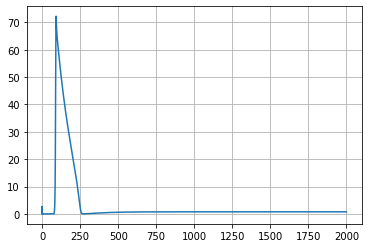

In [10]:
# get init vars without noise
aln.params.duration = dur_comp

# initial without noise
control0 = aln.getZeroControl()

for d in dict_list:
    
    print("Point = ", d['point'])
    aln.params.ext_exc_current = d['point'][0] * 5.
    aln.params.ext_inh_current = d['point'][1] * 5.
    aln.params.duration = dur_comp
    
    control0[0,0,:500] = -5.

    aln.run(control=control0)

    plt.plot(aln.t, aln.rates_exc[0,:])
    plt.show() 

    init_state_vars = np.zeros(( len(state_vars) ))
    for j in range(len(state_vars)):
        if aln.state[state_vars[j]].size == 1:
            init_state_vars[j] = aln.state[state_vars[j]][0]
        else:
            init_state_vars[j] = aln.state[state_vars[j]][0,-1]

    initVars = init_state_vars.copy()
    d['init_vars'] = initVars

Point =  [0.74 0.37]


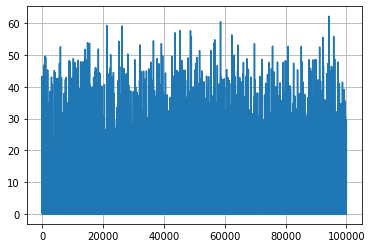

[23.192105   69.93081136]
0.0002954157700293939


In [11]:
for d in dict_list:
    
    print("Point = ", d['point'])
    aln.params.ext_exc_current = d['point'][0] * 5.
    aln.params.ext_inh_current = d['point'][1] * 5.
        
    aln.params.sigma_ou = 0.15
    aln.params.duration = dur_target_compute

    setinit(d['init_vars'], aln)

    target_rates_e = []
    target_rates_i = []

    aln.run(control=aln.getZeroControl())
    for t in range(len(aln.t)):
        if aln.rates_exc[0,t] < 10.:
            continue
        if aln.rates_inh[0,t] < 50.:
            continue

        target_rates_e.append(aln.rates_exc[0,t])
        target_rates_i.append(aln.rates_inh[0,t])

    plt.plot(aln.t, aln.rates_exc[0,:])
    plt.show()            

    aln.params.duration = dur
    target = aln.getZeroTarget()
    target[:,0,:] = np.mean(target_rates_e)
    target[:,1,:] = np.mean(target_rates_i)
    stddev = np.std(target_rates_e) + np.std(target_rates_i)
        
    for ind_s in range(len(d['sigma'])): 
        
        d['target'][ind_s] = target
        d['cost_params'][ind_s] = [1. / ( stddev * (1. - trans_time) * dur ), 0., 1.]
        
        
    print(d['target'][0][0,:,-1])
    print(d['cost_params'][0][0])
        
    file=open(dict_file, "wb")
    pickle.dump(dict_list, file)
    file.close()
    
    

In [15]:
#len(sigma_array), 4, N_max, max_it

##### METHOD 1
method_ind = 0
step_method_ind = 0

for d in dict_list:
        
        
    print("Point = ", d['point'])
    aln.params.ext_exc_current = d['point'][0] * 5.
    aln.params.ext_inh_current = d['point'][1] * 5.
    
    max_it = d['cost'].shape[3]
    
    for s_ind in range(len(d['sigma'])):
        
        print("sigma = ", d['sigma'][s_ind])
        
        s = d['sigma'][s_ind]
        aln.params.sigma_ou = s
        c_p = d['cost_params'][s_ind]
        cost.setParams(c_p[0], c_p[1], c_p[2])
        aln.params.duration = dur
        zero_init = aln.getZeroControl()
        
        target_ = d['target'][s_ind].copy()
        target_[0,0,:int(trans_time * dur / aln.params.dt)] = -1000
        target_[0,1,:int(trans_time * dur / aln.params.dt)] = -1000
        
        if np.amin(d['cost'][s_ind, method_ind, step_method_ind, :, 0]) == 0.:
        
            setinit(d['init_vars'], aln)
            cost_final = 0.

            for n_ in range(noise_realizations_final):
                state_ = fo.updateState(aln, zero_init)
                cost_final += cost.numba_cost_precision_int(1, T, dt, d['cost_params'][s_ind][0],
                                                               state_, target_, list(prec_vars) )

            d['cost'][s_ind, :, :, :, 0] = cost_final/noise_realizations_final
            
        print('cost = ', d['cost'][s_ind, 0, 0, 0])    
        
        for i_it in range(1,len(d['it_array'])):
            
            it = d['it_array'][i_it]
            print("iteration = ", it)
        
            for n_ind in range(len(d['N_array'])):

                if ( d['cost'][s_ind, method_ind, step_method_ind, n_ind, i_it] > 0.
                    and d['rep_ind'][s_ind, method_ind, step_method_ind, n_ind, i_it] > 0. ) :
                    continue
                    
                n_max = d['N_array'][n_ind]
                print("n max = ", n_max)

                aln.params.duration = dur
                     
                    
                n_ = 0
                control_sum = aln.getZeroControl()
                
                while n_ < n_max:
                
                    print('--------', n_)

                    aln.params.duration = dur
                    control_init = aln.getZeroControl()               
                    setinit(d['init_vars'], aln)
                    
                    c_vars = d['init']

                    bc, bs, c_, runtime, grad, phi, costnode, total_cost_mean_std = aln.A1(
                        control_init, d['target'][s_ind], c_scheme, u_mat, u_scheme, max_iteration_ = init_it,
                        tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
                        t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
                        control_variables_ = c_vars, prec_variables_ = prec_vars, transition_time_ = trans_time,
                        noise_real=0, init_params = d['init_vars'])
                    
                    if np.isnan(c_).any():
                        continue
                    
                    control_init = bc[:,:,n_pre:-n_post]
                    c_vars = [0,1]
                    aln.params.duration = dur
                    setinit(d['init_vars'], aln)
                    
                    bc, bs, c_, runtime, grad, phi, costnode, total_cost_mean_std = aln.A1(
                        control_init, d['target'][s_ind], c_scheme, u_mat, u_scheme, max_iteration_ = it-init_it,
                        tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
                        t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
                        control_variables_ = c_vars, prec_variables_ = prec_vars, transition_time_ = trans_time,
                        noise_real=0, init_params = d['init_vars'])
                    
                    if np.isnan(c_).any():
                        continue
                    
                    control_sum += bc[:,:,n_pre:-n_post]
                    n_ += 1

                control_init = control_sum / n_max
        
                aln.params.duration = dur
                setinit(d['init_vars'], aln)

                cost_final = 0.

                for j in range(noise_realizations_final):
                    state_ = fo.updateState(aln, control_init)
                    cost_final += cost.numba_cost_precision_int(1, T, dt, d['cost_params'][s_ind][0],
                                                                   state_, target_, list(prec_vars) )
                    cost_final += cost.numba_cost_sparsity_int(1, 6, T, d['cost_params'][s_ind][2],
                                                                   dt, control_init)

                d['cost'][s_ind, method_ind, step_method_ind, n_ind, i_it] = cost_final/noise_realizations_final
                print('cost = ', d['cost'][s_ind, method_ind, step_method_ind, n_ind, i_it])
                
                ###############################################################
                
                aln.params.duration = dur
                setinit(d['init_vars'], aln)
                     
                    
                n_ = 0
                control_sum = aln.getZeroControl()
                
                while n_ < n_max:
                
                    print('--------', n_)

                    aln.params.duration = dur
                    control_init1 = aln.getZeroControl()               
                    setinit(d['init_vars'], aln)
                    
                    c_vars = d['init']

                    bc, bs, c_, runtime, grad, phi, costnode, total_cost_mean_std = aln.A1(
                        control_init1, d['target'][s_ind], c_scheme, u_mat, u_scheme, max_iteration_ = init_it,
                        tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
                        t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
                        control_variables_ = c_vars, prec_variables_ = prec_vars, transition_time_ = trans_time,
                        noise_real=0, init_params = d['init_vars'])
                    
                    if np.isnan(c_).any():
                        continue
                    
                    control_init1 = bc[:,:,n_pre:-n_post]
                    c_vars = [0,1]
                    aln.params.duration = dur
                    setinit(d['init_vars'], aln)
                    
                    bc, bs, c_, runtime, grad, phi, costnode, total_cost_mean_std = aln.A1(
                        control_init1, d['target'][s_ind], c_scheme, u_mat, u_scheme, max_iteration_ = it-init_it,
                        tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
                        t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
                        control_variables_ = c_vars, prec_variables_ = prec_vars, transition_time_ = trans_time,
                        noise_real=0, init_params = d['init_vars'])
                    
                    if np.isnan(c_).any():
                        continue
                    
                    control_sum += bc[:,:,n_pre:-n_post]
                    n_ += 1

                control_init1 = control_sum / n_max
                
                d['rep_ind'][s_ind, method_ind, step_method_ind, n_ind, i_it] = rep_ind(control_init, control_init1)
                print('rep_ind = ', d['rep_ind'][s_ind, method_ind, step_method_ind, n_ind, i_it])
                
                file=open(dict_file, "wb")
                pickle.dump(dict_list, file)
                file.close()

Point =  [0.74 0.37]
sigma =  0.01
set cost params:  0.0002954157700293939 0.0 1.0
cost =  [97.94427958 50.00445427 31.16067769 51.77024676 15.07127575]
iteration =  6
iteration =  12
iteration =  18
iteration =  24
sigma =  0.03
set cost params:  0.0002954157700293939 0.0 1.0
cost =  [91.05527218 51.76513306 49.38422674 64.35843725 22.17999423]
iteration =  6
iteration =  12
iteration =  18
iteration =  24
sigma =  0.049999999999999996
set cost params:  0.0002954157700293939 0.0 1.0
cost =  [87.6808286  47.98858812 27.78046398 31.46723664 11.96618592]
iteration =  6
iteration =  12
iteration =  18
iteration =  24
sigma =  0.06999999999999999
set cost params:  0.0002954157700293939 0.0 1.0
cost =  [82.27789813 50.10879714 54.5913044  15.0577126  19.98938079]
iteration =  6
iteration =  12
iteration =  18
iteration =  24


In [21]:
#len(sigma_array), 4, N_max, max_it

##### METHOD 2
method_ind = 1
step_method_ind = 0

for d in dict_list:

        
    print("Point = ", d['point'])
    aln.params.ext_exc_current = d['point'][0] * 5.
    aln.params.ext_inh_current = d['point'][1] * 5.
    
    max_it = d['cost'].shape[3]
    
    for s_ind in range(len(d['sigma'])):
        
        print("sigma = ", d['sigma'][s_ind])
        
        s = d['sigma'][s_ind]
        aln.params.sigma_ou = s
        c_p = d['cost_params'][s_ind]
        cost.setParams(c_p[0], c_p[1], c_p[2])
        
        target_ = d['target'][s_ind].copy()
        target_[0,0,:int(trans_time * dur / aln.params.dt)] = -1000
        target_[0,1,:int(trans_time * dur / aln.params.dt)] = -1000
                
        for n_ind in range(len(d['N_array'])):
            
            n_ = d['N_array'][n_ind]
            
            print("n = ", n_)
            aln.params.duration = dur
        
            for i_it in range(1,len(d['it_array'])):
            
                it = d['it_array'][i_it]
                print("iteration = ", it)
                
                if ( d['cost'][s_ind, method_ind, step_method_ind, n_ind, i_it] > 0.
                    and d['rep_ind'][s_ind, method_ind, step_method_ind, n_ind, i_it] > 0. ) :
                    continue
                
                c_vars = d['init']
                aln.params.duration = dur
                setinit(d['init_vars'], aln)
                control_init = aln.getZeroControl()
                    
                
                bc, bs, c_, runtime, grad, phi, costnode, total_cost_mean_std = aln.A1(
                    control_init, d['target'][s_ind], c_scheme, u_mat, u_scheme, max_iteration_ = init_it,
                    tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
                    t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
                    control_variables_ = c_vars, prec_variables_ = prec_vars, transition_time_ = trans_time,
                    noise_real=n_, init_params = d['init_vars'], method='M2')
            
                control_init = bc[:,:,100:-100]
                c_vars = [0,1]
                aln.params.duration = dur
                setinit(d['init_vars'], aln)
                
                bc, bs, c_, runtime, grad, phi, costnode, total_cost_mean_std = aln.A1(
                    control_init, d['target'][s_ind], c_scheme, u_mat, u_scheme, max_iteration_=it-init_it,
                    tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
                    t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
                    control_variables_ = c_vars, prec_variables_ = prec_vars, transition_time_ = trans_time,
                    noise_real=n_, init_params = d['init_vars'], method='M2')

                control_init = bc[:,:,100:-100]
                aln.params.duration = dur
                setinit(d['init_vars'], aln)
                cost_final = 0.
                cs = cost.numba_cost_sparsity_int(1, 6, T, d['cost_params'][s_ind][2], dt, control_init)

                for j in range(noise_realizations_final):
                    state_ = fo.updateState(aln, control_init)
                    cost_final += cost.numba_cost_precision_int(1, T, dt, d['cost_params'][s_ind][0],
                                                                   state_, target_, list(prec_vars) )

                d['cost'][s_ind, method_ind, step_method_ind, n_ind, i_it] = (
                                cost_final / noise_realizations_final + cs )
                print('cost = ', d['cost'][s_ind, method_ind, step_method_ind, n_ind, i_it])
                
                c_vars = d['init']                    
                aln.params.duration = dur
                control_init1 = aln.getZeroControl()
                setinit(d['init_vars'], aln)
                
                bc, bs, c_, runtime, grad, phi, costnode, total_cost_mean_std = aln.A1(
                    control_init1, d['target'][s_ind], c_scheme, u_mat, u_scheme, max_iteration_ = init_it,
                    tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
                    t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
                    control_variables_ = c_vars, prec_variables_ = prec_vars, transition_time_ = trans_time,
                    noise_real=n_, init_params = d['init_vars'], method='M2')
            
                control_init1 = bc[:,:,100:-100]
                c_vars = [0,1]
                aln.params.duration = dur
                setinit(d['init_vars'], aln)
                
                bc, bs, c_, runtime, grad, phi, costnode, total_cost_mean_std = aln.A1(
                    control_init1, d['target'][s_ind], c_scheme, u_mat, u_scheme, max_iteration_=it-init_it,
                    tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
                    t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
                    control_variables_ = c_vars, prec_variables_ = prec_vars, transition_time_ = trans_time,
                    noise_real=n_, init_params = d['init_vars'], method='M2')

                control_init1 = bc[:,:,100:-100]
                d['rep_ind'][s_ind, method_ind, step_method_ind, n_ind, i_it] = rep_ind(control_init, control_init1)
                print('rep_ind = ', d['rep_ind'][s_ind, method_ind, step_method_ind, n_ind, i_it])
                
                file=open(dict_file, "wb")
                pickle.dump(dict_list, file)
                file.close()
                
    break

Point =  [0.74 0.37]
sigma =  0.01
set cost params:  0.0002954157700293939 0.0 1.0
n =  2
iteration =  6
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  98.95782750020327
Gradient descend method:  None
RUN  1 , total integrated cost =  48.68418390857582
RUN  2 , total integrated cost =  53.890261454044555
RUN  3 , total integrated cost =  42.33762476467246
RUN  3 , total integrated cost mean =  42.33762476467246
Improved over  3  iterations in  17.52476284094155  seconds by  57.21649733611473  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  46.183101786063986
Gradient descend method:  None
RUN  1 , total integrated cost =  36.766986657443404
RUN  2 , total integrated cost =  24.80630439640755
RUN  3 , total integrated cost =  16.54955422048219
RUN  3 , total integrated cost mean =  16.54955422048219
Improved over  3  iterations in  1.31110223592259  seconds by  64.1653471065122  percent.
cost =  15.299661539023951
interpolate adj

RUN  7 , total integrated cost =  7.811472629738275
RUN  8 , total integrated cost =  7.230217930976204
RUN  9 , total integrated cost =  6.999103468657875
RUN  10 , total integrated cost =  6.8386699625553415
RUN  11 , total integrated cost =  6.410918730414888
RUN  12 , total integrated cost =  6.4394017990092305
RUN  13 , total integrated cost =  6.069898512034246
RUN  14 , total integrated cost =  5.91922793398867
RUN  15 , total integrated cost =  5.73222318411391
RUN  16 , total integrated cost =  5.476844319092473
RUN  17 , total integrated cost =  5.457834943922019
RUN  18 , total integrated cost =  5.2593654178710665
RUN  19 , total integrated cost =  5.191884377412515
RUN  20 , total integrated cost =  5.161898157615893
RUN  21 , total integrated cost mean =  5.138093368628509
Improved over  21  iterations in  10.318932511960156  seconds by  81.74337936465315  percent.
cost =  5.218571738493233
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  98.5501717

RUN  13 , total integrated cost =  7.283575892872451
RUN  14 , total integrated cost =  6.846875450057377
step size too small or too large
step size too small or too large
RUN  15 , total integrated cost =  6.642985961004195
RUN  15 , total integrated cost mean =  6.642985961004195
Improved over  15  iterations in  37.42808884603437  seconds by  78.67429866498526  percent.
cost =  6.672775058178624
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  97.38680593320285
Gradient descend method:  None
RUN  1 , total integrated cost =  49.58530295239784
RUN  2 , total integrated cost =  40.95959749430345
RUN  3 , total integrated cost =  32.4178003947887
RUN  3 , total integrated cost mean =  32.4178003947887
Improved over  3  iterations in  4.297861411003396  seconds by  66.71232813916916  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  32.155632517951176
Gradient descend method:  None
RUN  1 , total integrated cost =  28.43499591144457


RUN  0 , total integrated cost =  34.15867086658383
Gradient descend method:  None
step size too small or too large
RUN  1 , total integrated cost =  30.511824704893595
RUN  2 , total integrated cost =  26.909916705639446
RUN  3 , total integrated cost =  24.056788703559263
RUN  4 , total integrated cost =  21.398142849973155
RUN  5 , total integrated cost =  12.89366155612397
RUN  6 , total integrated cost =  10.705873962907818
RUN  7 , total integrated cost =  9.220290540631046
RUN  8 , total integrated cost =  8.557931510288707
RUN  9 , total integrated cost =  7.969489214280571
RUN  9 , total integrated cost mean =  7.969489214280571
Improved over  9  iterations in  62.309080917038955  seconds by  76.66920576211052  percent.
cost =  7.802842547439858
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  98.03624563077739
Gradient descend method:  None
RUN  1 , total integrated cost =  46.768461346611026
RUN  2 , total integrated cost =  32.59516008600076
RUN  3 , 

RUN  1 , total integrated cost =  44.158319796783495
RUN  2 , total integrated cost =  38.2458670483601
RUN  3 , total integrated cost =  35.54440677410881
RUN  3 , total integrated cost mean =  35.54440677410881
Improved over  3  iterations in  12.711162969004363  seconds by  63.585057605183145  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  33.74281751653219
Gradient descend method:  None
step size too small or too large
RUN  1 , total integrated cost =  29.979910704341435
RUN  2 , total integrated cost =  26.954866894288905
RUN  3 , total integrated cost =  24.448205149297692
RUN  4 , total integrated cost =  21.89880551523945
RUN  5 , total integrated cost =  19.159215793248404
RUN  6 , total integrated cost =  20.175035933469257
RUN  7 , total integrated cost =  13.117447307256201
RUN  8 , total integrated cost =  10.788196457075339
RUN  9 , total integrated cost =  9.484173432228589
step size too small or too large
RUN  10 , total integrated cost

RUN  15 , total integrated cost =  5.545448266451879
RUN  15 , total integrated cost mean =  5.545448266451879
Improved over  15  iterations in  185.80738985992502  seconds by  84.37357504999747  percent.
cost =  5.597807052720549
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  97.94939834424653
Gradient descend method:  None
RUN  1 , total integrated cost =  42.891350250552385
RUN  2 , total integrated cost =  37.271767618360506
RUN  3 , total integrated cost =  37.78010409477442
RUN  3 , total integrated cost mean =  37.78010409477442
Improved over  3  iterations in  20.86070744995959  seconds by  61.42895746843187  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  37.260909903935094
Gradient descend method:  None
step size too small or too large
RUN  1 , total integrated cost =  32.90561834394317
RUN  2 , total integrated cost =  26.866784180015266
RUN  3 , total integrated cost =  22.16502089906232
RUN  4 , total integrated cos

RUN  1 , total integrated cost =  45.05988321991625
RUN  2 , total integrated cost =  56.93497887657121
RUN  3 , total integrated cost =  57.61426547701416
RUN  3 , total integrated cost mean =  57.61426547701416
Improved over  3  iterations in  0.8986725779250264  seconds by  39.09495127913056  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  32.28128159419127
Gradient descend method:  None
RUN  1 , total integrated cost =  30.40601691261623
RUN  2 , total integrated cost =  31.257455686874138
RUN  3 , total integrated cost =  31.581868857539284
RUN  3 , total integrated cost mean =  31.581868857539284
Improved over  3  iterations in  1.6828638300066814  seconds by  2.1666201033909402  percent.
rep_ind =  125.25658319317475
iteration =  12
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  89.75230840620706
Gradient descend method:  None
RUN  1 , total integrated cost =  46.496316743987116
RUN  2 , total integrated cost =  48.199186

cost =  38.484537906164746
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  75.97411968342054
Gradient descend method:  None
RUN  1 , total integrated cost =  72.82190594236341
RUN  2 , total integrated cost =  44.55871342693308
RUN  3 , total integrated cost =  54.249812822534324
RUN  3 , total integrated cost mean =  54.249812822534324
Improved over  3  iterations in  0.8628006350481883  seconds by  28.594351538932017  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  71.1101483480887
Gradient descend method:  None
RUN  1 , total integrated cost =  38.95769709017264
RUN  2 , total integrated cost =  39.56597589402155
RUN  3 , total integrated cost =  26.173032624254724
RUN  4 , total integrated cost =  21.81874170522836
RUN  5 , total integrated cost =  22.59032516118795
RUN  6 , total integrated cost =  19.38635553220942
RUN  7 , total integrated cost =  16.992450193349335
RUN  8 , total integrated cost =  14.782359531037528
RUN 

RUN  1 , total integrated cost =  62.130795622779814
RUN  2 , total integrated cost =  54.89807883061748
RUN  3 , total integrated cost =  55.353752547565854
RUN  3 , total integrated cost mean =  55.353752547565854
Improved over  3  iterations in  4.41307747492101  seconds by  39.862231705654594  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  52.93825634983589
Gradient descend method:  None
step size too small or too large
step size too small or too large
step size too small or too large
RUN  1 , total integrated cost =  37.23739222251144
RUN  2 , total integrated cost =  34.76211120721506
RUN  3 , total integrated cost =  35.237229511381464
step size too small or too large
RUN  4 , total integrated cost =  30.136724643009927
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  5 , total integrated cost =  32.05063462684812
RUN  6 , total integrated cost =  29.89112619

RUN  1 , total integrated cost =  65.59314028117234
step size too small or too large
RUN  2 , total integrated cost =  60.054689592310254
RUN  3 , total integrated cost =  54.89502705583604
RUN  3 , total integrated cost mean =  54.89502705583604
Improved over  3  iterations in  13.784743364085443  seconds by  36.72611458606302  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  52.64169353706614
Gradient descend method:  None
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  1 , total integrated cost =  43.52052745738328
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  2 , total integrated cost =  41.41456358749977
step size too small or too large
step size too small or too large
RUN  3 , total integrated cost =  34.44395352151287
RUN  4 , total integrated cost =  32.484444055772975


RUN  3 , total integrated cost =  36.609203765967216
RUN  4 , total integrated cost =  30.56736410624215
RUN  5 , total integrated cost =  28.914691177530337
step size too small or too large
RUN  6 , total integrated cost =  24.931018394967772
RUN  7 , total integrated cost =  22.855884652064574
step size too small or too large
RUN  8 , total integrated cost =  24.43345324379862
RUN  9 , total integrated cost =  25.0144355549476
step size too small or too large
step size too small or too large
RUN  10 , total integrated cost =  23.86733322773605
step size too small or too large
RUN  11 , total integrated cost =  23.94491803428692
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  12 , total integrated cost =  22.798127139913454
RUN  13 , total integrated cost =  22.95416945487225
step size too small or too large
RUN  14 , total integrated cost =  23.797649440867055
ste

RUN  3 , total integrated cost =  37.65905400074075
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  4 , total integrated cost =  35.12369791779358
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  5 , total integrated cost =  33.43618422952874
step size too small or too large
RUN  6 , total integrated cost =  32.77795650236095
step size too small or too large
step size too small or too large
RUN  7 , total integrated cost =  30.569084503174995
RUN  8 , total integrated cost =  30.303795494789146
RUN  9 , total integrated cost =  30.81618898623925
RUN  9 , total integrated cost mean =  30.81618898623925
Improved over  9  iterations in  133.576611545984

RUN  2 , total integrated cost =  55.029128655811874
step size too small or too large
RUN  3 , total integrated cost =  48.65067361250829
RUN  3 , total integrated cost mean =  48.65067361250829
Improved over  3  iterations in  23.10466330195777  seconds by  45.45445691615518  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  40.198201657659645
Gradient descend method:  None
step size too small or too large
step size too small or too large
RUN  1 , total integrated cost =  34.934462052668465
step size too small or too large
RUN  2 , total integrated cost =  32.644272155509505
step size too small or too large
RUN  3 , total integrated cost =  30.04744696906619
step size too small or too large
RUN  4 , total integrated cost =  28.282184195755917
RUN  5 , total integrated cost =  27.86194174504742
step size too small or too large
step size too small or too large
step size too small or too large
RUN  6 , total integrated cost =  27.177165733295624
step size t

RUN  3 , total integrated cost =  36.65009634161225
RUN  3 , total integrated cost mean =  36.65009634161225
Improved over  3  iterations in  1.498930910951458  seconds by  1.6182140916924226  percent.
rep_ind =  108.1938782172239
iteration =  12
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  94.08726564121969
Gradient descend method:  None
RUN  1 , total integrated cost =  60.710711926196694
RUN  2 , total integrated cost =  63.348579892336495
RUN  3 , total integrated cost =  58.7215181079126
RUN  3 , total integrated cost mean =  58.7215181079126
Improved over  3  iterations in  0.9032117510214448  seconds by  37.58824033442134  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  72.37274775373527
Gradient descend method:  None
RUN  1 , total integrated cost =  54.05895967824142
RUN  2 , total integrated cost =  49.413630607305564
RUN  3 , total integrated cost =  44.06515923483758
RUN  4 , total integrated cost =  44.01971671109

RUN  1 , total integrated cost =  45.33794752373673
RUN  2 , total integrated cost =  44.528190896174664
RUN  3 , total integrated cost =  43.96175365174702
RUN  4 , total integrated cost =  43.13965967358459
RUN  5 , total integrated cost =  43.54241230677235
RUN  6 , total integrated cost =  40.57808600544986
RUN  7 , total integrated cost =  40.5863889269992
RUN  8 , total integrated cost =  37.81009355538755
RUN  9 , total integrated cost =  37.353275472614754
step size too small or too large
step size too small or too large
RUN  10 , total integrated cost =  37.60815615928772
RUN  11 , total integrated cost =  37.13199397973368
RUN  12 , total integrated cost =  36.77949491052744
RUN  13 , total integrated cost =  36.15036351848249
RUN  14 , total integrated cost =  35.56461173058695
RUN  15 , total integrated cost =  35.02063511958702
RUN  16 , total integrated cost =  35.42842097547876
RUN  17 , total integrated cost =  35.49322926131684
RUN  18 , total integrated cost =  34.458

RUN  3 , total integrated cost =  33.20893363131504
RUN  4 , total integrated cost =  35.07070203499182
RUN  5 , total integrated cost =  34.79248272314144
RUN  6 , total integrated cost =  32.62204801377824
step size too small or too large
step size too small or too large
RUN  7 , total integrated cost =  29.00691946602612
RUN  8 , total integrated cost =  29.316954617850048
RUN  9 , total integrated cost =  27.57580463747933
step size too small or too large
step size too small or too large
RUN  10 , total integrated cost =  25.678717814862814
RUN  11 , total integrated cost =  29.154339903418766
RUN  12 , total integrated cost =  30.750403707503956
RUN  13 , total integrated cost =  28.91682761750704
RUN  14 , total integrated cost =  29.579956182646818
RUN  15 , total integrated cost =  29.097486053689835
RUN  15 , total integrated cost mean =  29.097486053689835
Improved over  15  iterations in  39.632554952055216  seconds by  48.290429844383134  percent.
cost =  30.193269841284426

step size too small or too large
step size too small or too large
step size too small or too large
RUN  3 , total integrated cost =  34.37465659554035
RUN  3 , total integrated cost mean =  34.37465659554035
Improved over  3  iterations in  24.85503852996044  seconds by  37.79260270418771  percent.
cost =  37.53005367057857
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  91.65155377676933
Gradient descend method:  None
RUN  1 , total integrated cost =  77.83869905184818
RUN  2 , total integrated cost =  58.935855936486846
RUN  3 , total integrated cost =  45.737563514791916
RUN  3 , total integrated cost mean =  45.737563514791916
Improved over  3  iterations in  13.318523325957358  seconds by  50.096248639502186  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  45.29538808650425
Gradient descend method:  None
RUN  1 , total integrated cost =  38.521112676603444
step size too small or too large
RUN  2 , total integrated cost =  37

step size too small or too large
RUN  5 , total integrated cost =  27.89416966602893
RUN  6 , total integrated cost =  26.32958254243535
RUN  7 , total integrated cost =  25.492356255780845
RUN  8 , total integrated cost =  22.9565961581536
step size too small or too large
step size too small or too large
RUN  9 , total integrated cost =  24.697569166263104
step size too small or too large
step size too small or too large
step size too small or too large
RUN  10 , total integrated cost =  20.950413691015466
RUN  11 , total integrated cost =  20.489854542761783
RUN  12 , total integrated cost =  13.789358401042575
RUN  13 , total integrated cost =  13.708861549832685
RUN  14 , total integrated cost =  15.029193330437444
RUN  15 , total integrated cost =  11.677989295612644
RUN  15 , total integrated cost mean =  11.677989295612644
Improved over  15  iterations in  123.06911197595764  seconds by  80.32266608418584  percent.
rep_ind =  73.07527579894848
iteration =  24
interpolate adjoint

RUN  0 , total integrated cost =  53.28433146514656
Gradient descend method:  None
step size too small or too large
RUN  1 , total integrated cost =  43.966612963248735
RUN  2 , total integrated cost =  38.73449231161739
RUN  3 , total integrated cost =  37.27612983392825
RUN  3 , total integrated cost mean =  37.27612983392825
Improved over  3  iterations in  39.34433816000819  seconds by  30.042981099780377  percent.
rep_ind =  62.6293398057543
iteration =  12
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  87.445489659535
Gradient descend method:  None
RUN  1 , total integrated cost =  76.21899146045567
RUN  2 , total integrated cost =  60.088006996496624
step size too small or too large
RUN  3 , total integrated cost =  57.14686351411069
RUN  3 , total integrated cost mean =  57.14686351411069
Improved over  3  iterations in  23.324780993978493  seconds by  34.64858652331941  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  54

RUN  4 , total integrated cost =  35.96537315941174
step size too small or too large
step size too small or too large
step size too small or too large
RUN  5 , total integrated cost =  33.90127577109842
step size too small or too large
step size too small or too large
step size too small or too large
RUN  6 , total integrated cost =  32.70208989493565
step size too small or too large
step size too small or too large
step size too small or too large
RUN  7 , total integrated cost =  30.495058434320978
RUN  8 , total integrated cost =  27.56700483762233
step size too small or too large
step size too small or too large
step size too small or too large
RUN  9 , total integrated cost =  26.91905676324021
step size too small or too large
step size too small or too large
RUN  10 , total integrated cost =  23.91923136674999
step size too small or too large
RUN  11 , total integrated cost =  19.444292839878766
step size too small or too large
step size too small or too large
RUN  12 , total int

step size too small or too large
RUN  18 , total integrated cost =  11.790449438697369
step size too small or too large
RUN  19 , total integrated cost =  11.547814864839184
step size too small or too large
step size too small or too large
RUN  20 , total integrated cost =  10.760627149363524
RUN  21 , total integrated cost mean =  10.531380591979655
Improved over  21  iterations in  302.12765508599114  seconds by  77.16894009072575  percent.
rep_ind =  44.99613043963594
sigma =  0.06999999999999999
set cost params:  0.0002954157700293939 0.0 1.0
n =  2
iteration =  6
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  83.50460276091391
Gradient descend method:  None
RUN  1 , total integrated cost =  85.04025354099917
RUN  2 , total integrated cost =  51.289316223472106
RUN  3 , total integrated cost =  44.27566179189466
RUN  3 , total integrated cost mean =  44.27566179189466
Improved over  3  iterations in  0.8146502180024981  seconds by  46.97817805485231  percen

RUN  1 , total integrated cost =  34.22798415130439
RUN  2 , total integrated cost =  39.318118348668804
RUN  3 , total integrated cost =  32.50473568881477
RUN  4 , total integrated cost =  35.55227187069952
RUN  5 , total integrated cost =  31.56111833912151
RUN  6 , total integrated cost =  35.28230402430543
RUN  7 , total integrated cost =  26.319300348819098
RUN  8 , total integrated cost =  31.875997748262293
RUN  9 , total integrated cost =  35.60552076234039
RUN  10 , total integrated cost =  28.598449843969167
RUN  11 , total integrated cost =  31.597052943338277
RUN  12 , total integrated cost =  29.5082985970989
RUN  13 , total integrated cost =  20.60237276212407
RUN  14 , total integrated cost =  22.045289745204883
RUN  15 , total integrated cost =  15.996932282901732
RUN  16 , total integrated cost =  13.175064140153834
RUN  17 , total integrated cost =  13.86352816289385
RUN  18 , total integrated cost =  16.106022997853145
RUN  19 , total integrated cost =  11.346338759

RUN  4 , total integrated cost =  32.47896737609246
RUN  5 , total integrated cost =  31.278692282594854
RUN  6 , total integrated cost =  28.415138086106303
RUN  7 , total integrated cost =  30.538196748496365
step size too small or too large
RUN  8 , total integrated cost =  31.82544854403742
RUN  9 , total integrated cost =  22.619661286523797
RUN  10 , total integrated cost =  24.714360242126215
RUN  11 , total integrated cost =  19.343450076741547
RUN  12 , total integrated cost =  19.990660078686613
step size too small or too large
step size too small or too large
RUN  13 , total integrated cost =  18.616821708704553
RUN  14 , total integrated cost =  17.887914626282168
RUN  15 , total integrated cost =  19.087471614377332
RUN  15 , total integrated cost mean =  19.087471614377332
Improved over  15  iterations in  40.51304961997084  seconds by  64.0938258032835  percent.
cost =  25.129368521077815
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  87.40600145

RUN  3 , total integrated cost =  60.052385991590924
RUN  3 , total integrated cost mean =  60.052385991590924
Improved over  3  iterations in  12.897474870085716  seconds by  27.55833684984121  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  58.65217201028543
Gradient descend method:  None
step size too small or too large
step size too small or too large
RUN  1 , total integrated cost =  41.91674657757307
RUN  2 , total integrated cost =  41.90784786827426
step size too small or too large
step size too small or too large
step size too small or too large
RUN  3 , total integrated cost =  36.1469529844754
RUN  3 , total integrated cost mean =  36.1469529844754
Improved over  3  iterations in  24.204443104099482  seconds by  38.370648953739426  percent.
rep_ind =  60.49382892402754
iteration =  12
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  80.71545263911786
Gradient descend method:  None
RUN  1 , total integrated cost =  77.46

step size too small or too large
RUN  15 , total integrated cost =  11.733616450624142
RUN  15 , total integrated cost mean =  11.733616450624142
Improved over  15  iterations in  127.0294461150188  seconds by  80.54327303648131  percent.
rep_ind =  70.31916817145276
iteration =  24
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  80.10918818445818
Gradient descend method:  None
step size too small or too large
RUN  1 , total integrated cost =  69.30123897186806
RUN  2 , total integrated cost =  64.83139769002663
RUN  3 , total integrated cost =  59.08811070804227
RUN  3 , total integrated cost mean =  59.08811070804227
Improved over  3  iterations in  13.81689220503904  seconds by  26.240532394377908  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  53.992769820335816
Gradient descend method:  None
RUN  1 , total integrated cost =  44.82508785300331
step size too small or too large
step size too small or too large
step size too sm

RUN  0 , total integrated cost =  80.07297656459419
Gradient descend method:  None
step size too small or too large
RUN  1 , total integrated cost =  68.8449872519477
step size too small or too large
RUN  2 , total integrated cost =  64.74066843486662
step size too small or too large
step size too small or too large
step size too small or too large
RUN  3 , total integrated cost =  54.39949650736569
RUN  3 , total integrated cost mean =  54.39949650736569
Improved over  3  iterations in  24.293395668035373  seconds by  32.06260233940213  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  59.31407910566681
Gradient descend method:  None
step size too small or too large
RUN  1 , total integrated cost =  45.752913862593076
step size too small or too large
step size too small or too large
step size too small or too large
RUN  2 , total integrated cost =  41.974524058848026
step size too small or too large
step size too small or too large
RUN  3 , total integra

RUN  9 , total integrated cost =  22.895225298006103
step size too small or too large
RUN  10 , total integrated cost =  22.114632333718614
step size too small or too large
step size too small or too large
RUN  11 , total integrated cost =  22.068839754684486
step size too small or too large
step size too small or too large
step size too small or too large
RUN  12 , total integrated cost =  20.98129984930564
RUN  13 , total integrated cost =  16.486422965937255
step size too small or too large
step size too small or too large
RUN  14 , total integrated cost =  15.20134456915823
step size too small or too large
step size too small or too large
step size too small or too large
RUN  15 , total integrated cost =  13.580640341027411
RUN  15 , total integrated cost mean =  13.580640341027411
Improved over  15  iterations in  204.70284814597107  seconds by  77.91328010060266  percent.
rep_ind =  49.069771287925334
iteration =  24
interpolate adjoint :  True True True
RUN  0 , total integrated

RUN  21 , total integrated cost mean =  10.627004825235677
Improved over  21  iterations in  307.78288344398607  seconds by  79.33268742192881  percent.
rep_ind =  53.982401271399


In [22]:
#len(sigma_array), 4, N_max, max_it

##### METHOD 3
method_ind = 2
step_method_ind = 0

for d in dict_list:

        
    print("Point = ", d['point'])
    aln.params.ext_exc_current = d['point'][0] * 5.
    aln.params.ext_inh_current = d['point'][1] * 5.
    
    max_it = d['cost'].shape[3]
    
    for s_ind in range(len(d['sigma'])):
        
        print("sigma = ", d['sigma'][s_ind])
        
        s = d['sigma'][s_ind]
        aln.params.sigma_ou = s
        c_p = d['cost_params'][s_ind]
        cost.setParams(c_p[0], c_p[1], c_p[2])
        
        target_ = d['target'][s_ind].copy()
        target_[0,0,:int(trans_time * dur / aln.params.dt)] = -1000
        target_[0,1,:int(trans_time * dur / aln.params.dt)] = -1000
                
        for n_ind in range(len(d['N_array'])):
            
            n_ = d['N_array'][n_ind]
            
            print("n = ", n_)
            aln.params.duration = dur
        
            for i_it in range(1,len(d['it_array'])):
                
                print('cost = ', d['cost'][s_ind, method_ind, step_method_ind, n_ind, i_it])
            
                it = d['it_array'][i_it]
                print("iteration = ", it)
                
                if d['cost'][s_ind, method_ind, step_method_ind, n_ind, i_it] > 0.:
                    continue
                
                c_vars = d['init']
                aln.params.duration = dur
                setinit(d['init_vars'], aln)
                control_init = aln.getZeroControl()
                    
                
                bc, bs, c_, runtime, grad, phi, costnode, total_cost_mean_std = aln.A1(
                    control_init, d['target'][s_ind], c_scheme, u_mat, u_scheme, max_iteration_ = init_it,
                    tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
                    t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
                    control_variables_ = c_vars, prec_variables_ = prec_vars, transition_time_ = trans_time,
                    noise_real=n_, init_params = d['init_vars'], method='M3')
            
                control_init = bc[:,:,100:-100]
                c_vars = [0,1]
                aln.params.duration = dur
                setinit(d['init_vars'], aln)
                
                bc, bs, c_, runtime, grad, phi, costnode, total_cost_mean_std = aln.A1(
                    control_init, d['target'][s_ind], c_scheme, u_mat, u_scheme, max_iteration_=it-init_it,
                    tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
                    t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
                    control_variables_ = c_vars, prec_variables_ = prec_vars, transition_time_ = trans_time,
                    noise_real=n_, init_params = d['init_vars'], method='M3')

                control_init = bc[:,:,100:-100]
                aln.params.duration = dur
                setinit(d['init_vars'], aln)
                cost_final = 0.
                cs = cost.numba_cost_sparsity_int(1, 6, T, d['cost_params'][s_ind][2], dt, control_init)

                for j in range(noise_realizations_final):
                    state_ = fo.updateState(aln, control_init)
                    cost_final += cost.numba_cost_precision_int(1, T, dt, d['cost_params'][s_ind][0],
                                                                   state_, target_, list(prec_vars) )

                d['cost'][s_ind, method_ind, step_method_ind, n_ind, i_it] = (
                                cost_final / noise_realizations_final + cs )
                print('cost = ', d['cost'][s_ind, method_ind, step_method_ind, n_ind, i_it])
                
                c_vars = d['init']                    
                aln.params.duration = dur
                control_init1 = aln.getZeroControl()
                setinit(d['init_vars'], aln)
                
                bc, bs, c_, runtime, grad, phi, costnode, total_cost_mean_std = aln.A1(
                    control_init1, d['target'][s_ind], c_scheme, u_mat, u_scheme, max_iteration_ = init_it,
                    tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
                    t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
                    control_variables_ = c_vars, prec_variables_ = prec_vars, transition_time_ = trans_time,
                    noise_real=n_, init_params = d['init_vars'], method='M3')
            
                control_init1 = bc[:,:,100:-100]
                c_vars = [0,1]
                aln.params.duration = dur
                setinit(d['init_vars'], aln)
                
                bc, bs, c_, runtime, grad, phi, costnode, total_cost_mean_std = aln.A1(
                    control_init1, d['target'][s_ind], c_scheme, u_mat, u_scheme, max_iteration_=it-init_it,
                    tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
                    t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
                    control_variables_ = c_vars, prec_variables_ = prec_vars, transition_time_ = trans_time,
                    noise_real=n_, init_params = d['init_vars'], method='M3')

                control_init1 = bc[:,:,100:-100]
                d['rep_ind'][s_ind, method_ind, step_method_ind, n_ind, i_it] = rep_ind(control_init, control_init1)
                print('rep_ind = ', d['rep_ind'][s_ind, method_ind, step_method_ind, n_ind, i_it])
                
                file=open(dict_file, "wb")
                pickle.dump(dict_list, file)
                file.close()
                
    break

Point =  [0.74 0.37]
sigma =  0.01
set cost params:  0.0002954157700293939 0.0 1.0
n =  2
cost =  0.0
iteration =  6
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  97.81933783088814
Gradient descend method:  None
RUN  1 , total integrated cost =  40.30903003116335
RUN  2 , total integrated cost =  38.30678895096181
RUN  3 , total integrated cost =  37.36458940508389
RUN  3 , total integrated cost mean =  37.36458940508389
Improved over  3  iterations in  15.380571943009272  seconds by  61.80245109644836  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  38.36713912288687
Gradient descend method:  None
RUN  1 , total integrated cost =  26.845160150548395
RUN  2 , total integrated cost =  25.75437771014166
RUN  3 , total integrated cost =  20.561776953830794
RUN  3 , total integrated cost mean =  20.561776953830794
Improved over  3  iterations in  1.3791225519962609  seconds by  46.40784425449843  percent.
cost =  25.27779898275924


RUN  6 , total integrated cost =  7.031559332436952
RUN  7 , total integrated cost =  6.9945624775481505
RUN  8 , total integrated cost =  6.925574236624784
RUN  9 , total integrated cost =  6.7296839930653825
RUN  10 , total integrated cost =  6.547590643943574
RUN  11 , total integrated cost =  5.051566255610532
RUN  12 , total integrated cost =  4.775151051846766
RUN  13 , total integrated cost =  4.698945592072761
RUN  14 , total integrated cost =  4.569104555925588
RUN  15 , total integrated cost =  4.573487017501048
RUN  16 , total integrated cost =  4.602049691416665
RUN  17 , total integrated cost =  4.521307827843205
RUN  18 , total integrated cost =  4.588987963223602
RUN  19 , total integrated cost =  4.479531934568235
RUN  20 , total integrated cost =  4.347356677902793
RUN  21 , total integrated cost mean =  4.2926177303951984
Improved over  21  iterations in  10.094703481998295  seconds by  85.40241647607819  percent.
cost =  4.430921262897722
interpolate adjoint :  True 

RUN  7 , total integrated cost =  22.579115781336487
RUN  8 , total integrated cost =  17.667376182572422
RUN  9 , total integrated cost =  14.010854780367117
RUN  10 , total integrated cost =  11.962465322405901
RUN  11 , total integrated cost =  9.134691955565843
RUN  12 , total integrated cost =  8.305123713707482
RUN  13 , total integrated cost =  6.979235999835207
RUN  14 , total integrated cost =  6.333074467869076
RUN  15 , total integrated cost =  6.193979936980741
RUN  15 , total integrated cost mean =  6.193979936980741
Improved over  15  iterations in  35.059704951010644  seconds by  82.46233676607328  percent.
cost =  6.2088246549614725
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  97.91946916249574
Gradient descend method:  None
RUN  1 , total integrated cost =  37.82355643021483
RUN  2 , total integrated cost =  39.36899804793391
RUN  3 , total integrated cost =  30.518477220709592
RUN  3 , total integrated cost mean =  30.518477220709592
Improve

RUN  1 , total integrated cost =  29.269315800831983
RUN  2 , total integrated cost =  25.914727554445445
RUN  3 , total integrated cost =  16.935599672284322
step size too small or too large
RUN  4 , total integrated cost =  16.54618950867181
RUN  5 , total integrated cost =  16.062855691822683
RUN  6 , total integrated cost =  11.470222477205946
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  7 , total integrated cost =  11.088113828408614
RUN  8 , total integrated cost =  13.153241329611172
step size too small or too large
step size too small or too large
RUN  9 , total integrated cost =  12.74672424383935
RUN  9 , total integrated cost mean =  12.74672424383935
Improved over  9  iterations in  67.47359731304459  seconds by  67.7659833043731  percent.
cost =  16.432265442593156
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  97.98726876074

RUN  19 , total integrated cost =  5.076630051097137
RUN  20 , total integrated cost =  4.9957344049562105
RUN  21 , total integrated cost mean =  4.8839976978407496
Improved over  21  iterations in  146.5302244760096  seconds by  87.93202256747361  percent.
cost =  4.879522968027945
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  97.9561837980492
Gradient descend method:  None
RUN  1 , total integrated cost =  40.76284046851933
RUN  2 , total integrated cost =  39.77487575113064
RUN  3 , total integrated cost =  36.77288671277633
RUN  3 , total integrated cost mean =  36.77288671277633
Improved over  3  iterations in  11.90650939499028  seconds by  62.45986186171877  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  36.98381559535398
Gradient descend method:  None
RUN  1 , total integrated cost =  26.758082819710964
RUN  2 , total integrated cost =  19.17485139031822
RUN  3 , total integrated cost =  17.842026972094484
RUN  4 , to

RUN  5 , total integrated cost =  21.755597177060917
RUN  6 , total integrated cost =  17.087591115997206
step size too small or too large
RUN  7 , total integrated cost =  14.066080544062713
RUN  8 , total integrated cost =  12.325522723702154
RUN  9 , total integrated cost =  11.234356882095222
step size too small or too large
RUN  10 , total integrated cost =  10.749711823971282
RUN  11 , total integrated cost =  10.055809527713286
RUN  12 , total integrated cost =  9.698121163214113
RUN  13 , total integrated cost =  9.245313530803053
step size too small or too large
RUN  14 , total integrated cost =  8.966832937297383
step size too small or too large
step size too small or too large
step size too small or too large
RUN  15 , total integrated cost =  8.601101193487976
RUN  15 , total integrated cost mean =  8.601101193487976
Improved over  15  iterations in  180.04116864001844  seconds by  73.22373459472239  percent.
cost =  8.641588124424683
interpolate adjoint :  True True True
R

RUN  20 , total integrated cost =  4.550174447658434
RUN  21 , total integrated cost mean =  4.148710701682018
Improved over  21  iterations in  243.9864591669757  seconds by  86.67140316468353  percent.
rep_ind =  74.99393129093184
sigma =  0.03
set cost params:  0.0002954157700293939 0.0 1.0
n =  2
cost =  0.0
iteration =  6
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  84.50877126044821
Gradient descend method:  None
RUN  1 , total integrated cost =  93.59321702594278
RUN  2 , total integrated cost =  78.81161667144718
RUN  3 , total integrated cost =  75.41150128401924
RUN  3 , total integrated cost mean =  75.41150128401924
Improved over  3  iterations in  0.8671413339907303  seconds by  10.764882556855582  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  71.12921768539442
Gradient descend method:  None
RUN  1 , total integrated cost =  56.225282297023945
RUN  2 , total integrated cost =  54.94621980841907
RUN  3 , total in

RUN  3 , total integrated cost =  30.797765452064393
RUN  4 , total integrated cost =  31.114411447464498
RUN  5 , total integrated cost =  28.448194395365924
RUN  6 , total integrated cost =  26.587629687015145
RUN  7 , total integrated cost =  26.84020073101832
RUN  8 , total integrated cost =  24.875639656032767
RUN  9 , total integrated cost =  25.125100466971215
RUN  10 , total integrated cost =  23.35999653680828
RUN  11 , total integrated cost =  22.98780580972202
RUN  12 , total integrated cost =  18.663172655237624
RUN  13 , total integrated cost =  19.077262435992903
RUN  14 , total integrated cost =  17.5035657475302
RUN  15 , total integrated cost =  17.940858355317257
RUN  16 , total integrated cost =  18.194442840800143
RUN  17 , total integrated cost =  17.41345607652892
RUN  18 , total integrated cost =  17.74527573466511
RUN  19 , total integrated cost =  18.05633729655392
RUN  20 , total integrated cost =  18.767826959937693
step size too small or too large
RUN  21 , 

step size too small or too large
RUN  5 , total integrated cost =  52.54227196446967
RUN  6 , total integrated cost =  51.067047240459054
step size too small or too large
RUN  7 , total integrated cost =  50.062904823226305
RUN  8 , total integrated cost =  52.133802988724085
RUN  9 , total integrated cost =  49.363053778726126
step size too small or too large
RUN  10 , total integrated cost =  43.77570152597378
RUN  11 , total integrated cost =  41.990791359362774
step size too small or too large
step size too small or too large
RUN  12 , total integrated cost =  44.32370874112664
RUN  13 , total integrated cost =  36.34603072451746
RUN  14 , total integrated cost =  34.71660789371486
RUN  15 , total integrated cost =  33.34422160911372
RUN  15 , total integrated cost mean =  33.34422160911372
Improved over  15  iterations in  39.50387595198117  seconds by  43.68010012030871  percent.
cost =  37.7169619619017
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  94.9

step size too small or too large
step size too small or too large
RUN  1 , total integrated cost =  50.84444482396456
RUN  2 , total integrated cost =  45.80031436246496
RUN  3 , total integrated cost =  39.12611845564693
RUN  3 , total integrated cost mean =  39.12611845564693
Improved over  3  iterations in  19.283001739997417  seconds by  30.86191119080236  percent.
rep_ind =  248.2635390884896
cost =  0.0
iteration =  12
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  94.36681131690074
Gradient descend method:  None
RUN  1 , total integrated cost =  53.070810396301425
RUN  2 , total integrated cost =  38.471639700556544
step size too small or too large
RUN  3 , total integrated cost =  37.002955573335484
RUN  3 , total integrated cost mean =  37.002955573335484
Improved over  3  iterations in  12.687320986995474  seconds by  60.788167940662  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  39.73446691210357
Gradient descend me

RUN  3 , total integrated cost =  49.55811528243587
step size too small or too large
RUN  4 , total integrated cost =  45.922448857076695
RUN  5 , total integrated cost =  40.747968851751274
RUN  6 , total integrated cost =  36.99216794299423
RUN  7 , total integrated cost =  35.510250268584706
RUN  8 , total integrated cost =  33.04167300353053
RUN  9 , total integrated cost =  32.28791481441337
RUN  10 , total integrated cost =  31.90924793346827
step size too small or too large
step size too small or too large
step size too small or too large
RUN  11 , total integrated cost =  31.338853611246073
step size too small or too large
RUN  12 , total integrated cost =  30.09303811165481
RUN  13 , total integrated cost =  29.969182943097348
step size too small or too large
RUN  14 , total integrated cost =  29.90659551316383
RUN  15 , total integrated cost =  29.92262945912001
RUN  16 , total integrated cost =  29.60259801411829
RUN  17 , total integrated cost =  29.481619854544878
RUN  18 

step size too small or too large
step size too small or too large
RUN  2 , total integrated cost =  40.76922263516885
step size too small or too large
RUN  3 , total integrated cost =  38.03412800531242
RUN  3 , total integrated cost mean =  38.03412800531242
Improved over  3  iterations in  20.695418798946775  seconds by  58.36810120633385  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  37.566492721398824
Gradient descend method:  None
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  1 , total integrated cost =  36.14449797224331
RUN  2 , total integrated cost =  34.85094457884741
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  3 , total integrated cost =  34.39369600969511
RUN  4 , total integrated cost =  33.654524233797325
step size too small

step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  15 , total integrated cost =  7.875928935650952
RUN  16 , total integrated cost =  7.468865422120768
step size too small or too large
step size too small or too large
step size too small or too large
RUN  17 , total integrated cost =  7.402152271299769
RUN  18 , total integrated cost =  8.083650142308473
RUN  19 , total integrated cost =  7.37020689533344
step size too small or too large
step size too small or too large
step size too small or too large
RUN  20 , total integrated cost =  7.402486045201342
RUN  21 , total integrated cost mean =  7.337504952146853
Improved over  21  iterations in  254.8154107159935  seconds by  79.39830597833387  percent.
cost =  7.515632610657611
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  92.47248643795677
Gradient descend method:  None
RUN  1 , total integra

RUN  1 , total integrated cost =  50.134879601845086
RUN  2 , total integrated cost =  48.49810287985747
RUN  3 , total integrated cost =  37.77991712000664
RUN  4 , total integrated cost =  35.44838485909678
RUN  5 , total integrated cost =  34.521390977291944
RUN  6 , total integrated cost =  35.227997332229535
RUN  7 , total integrated cost =  30.75922235099815
RUN  8 , total integrated cost =  30.390836208537962
RUN  9 , total integrated cost =  28.645171168191148
RUN  10 , total integrated cost =  25.843005250967707
RUN  11 , total integrated cost =  22.837139465471605
RUN  12 , total integrated cost =  19.495222410788415
RUN  13 , total integrated cost =  47.72231816597206
RUN  14 , total integrated cost =  15.740102693604165
RUN  15 , total integrated cost =  15.40786357932716
RUN  15 , total integrated cost mean =  15.40786357932716
Improved over  15  iterations in  6.639920640969649  seconds by  69.684402731327  percent.
cost =  26.54271586312835
interpolate adjoint :  True Tr

RUN  2 , total integrated cost =  49.29864840328561
step size too small or too large
step size too small or too large
RUN  3 , total integrated cost =  50.82180635317904
RUN  3 , total integrated cost mean =  50.82180635317904
Improved over  3  iterations in  4.848524363012984  seconds by  45.82980029278162  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  44.210470255780464
Gradient descend method:  None
RUN  1 , total integrated cost =  45.377675292534654
step size too small or too large
step size too small or too large
RUN  2 , total integrated cost =  43.999938974572615
RUN  3 , total integrated cost =  37.13988638827849
step size too small or too large
step size too small or too large
step size too small or too large
RUN  4 , total integrated cost =  37.45869281440406
step size too small or too large
step size too small or too large
RUN  5 , total integrated cost =  39.09303902565983
RUN  6 , total integrated cost =  25.401351927674433
RUN  7 , tota

RUN  2 , total integrated cost =  55.52206982353424
RUN  3 , total integrated cost =  55.477517472520006
RUN  3 , total integrated cost mean =  55.477517472520006
Improved over  3  iterations in  4.053467692923732  seconds by  40.27814437614651  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  51.407363806795765
Gradient descend method:  None
RUN  1 , total integrated cost =  43.064836031834474
RUN  2 , total integrated cost =  41.560482727904784
RUN  3 , total integrated cost =  38.242600103616155
RUN  4 , total integrated cost =  30.690714627571776
RUN  5 , total integrated cost =  31.523883251272444
RUN  6 , total integrated cost =  29.148525989089013
RUN  7 , total integrated cost =  29.794909853763528
RUN  8 , total integrated cost =  27.835692399144136
RUN  9 , total integrated cost =  26.69365316027604
step size too small or too large
RUN  10 , total integrated cost =  21.589065997341283
RUN  11 , total integrated cost =  15.4709411882214
RUN  12 

RUN  10 , total integrated cost =  14.910400173778148
RUN  11 , total integrated cost =  14.14178871838322
step size too small or too large
step size too small or too large
RUN  12 , total integrated cost =  13.93566088814999
RUN  13 , total integrated cost =  13.848150518669161
RUN  14 , total integrated cost =  13.905099445537617
step size too small or too large
step size too small or too large
step size too small or too large
RUN  15 , total integrated cost =  14.251159919876612
RUN  15 , total integrated cost mean =  14.251159919876612
Improved over  15  iterations in  102.01201273303013  seconds by  66.34262971608581  percent.
cost =  14.230550203285427
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  85.29582341172014
Gradient descend method:  None
step size too small or too large
RUN  1 , total integrated cost =  58.02192544208735
RUN  2 , total integrated cost =  60.40683372025447
RUN  3 , total integrated cost =  57.053550751426165
RUN  3 , total integra

step size too small or too large
step size too small or too large
RUN  1 , total integrated cost =  58.30301268011466
step size too small or too large
RUN  2 , total integrated cost =  54.970868866707434
step size too small or too large
step size too small or too large
RUN  3 , total integrated cost =  55.94863840495166
RUN  3 , total integrated cost mean =  55.94863840495166
Improved over  3  iterations in  24.04290688992478  seconds by  37.89217602014029  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  53.55121684675672
Gradient descend method:  None
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  1 , total integrated cost =  55.6616028212639
RUN  2 , total integrated cost =  43.36819708384987
RUN  3 , total integrated cost =  40.92620906838357
RUN  3 , total integrated cost mean =  40.9262090683835

RUN  3 , total integrated cost =  73.2031130084187
RUN  3 , total integrated cost mean =  73.2031130084187
Improved over  3  iterations in  22.928973992005922  seconds by  23.296034547992832  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  73.78771094738215
Gradient descend method:  None
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  1 , total integrated cost =  58.89052811030179
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  2 , total integrated cost =  61.46677482941601
step size too small or too large
RUN  3 , total integrated cost =  53.14566327944233
RUN  4 , total integrated cost =  45.950131305044216
step size too small or too large
step size too small or too large
step size too small or too large
RUN  5 

RUN  3 , total integrated cost =  64.07278324729191
RUN  3 , total integrated cost mean =  64.07278324729191
Improved over  3  iterations in  0.8854067160282284  seconds by  36.12985585256604  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  62.867630122398296
Gradient descend method:  None
RUN  1 , total integrated cost =  46.858336913852256
RUN  2 , total integrated cost =  36.0891047165997
RUN  3 , total integrated cost =  33.17100431807385
RUN  3 , total integrated cost mean =  33.17100431807385
Improved over  3  iterations in  1.3663846029667184  seconds by  47.23675084698989  percent.
cost =  38.50288061274447
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  76.31445899629114
Gradient descend method:  None
RUN  1 , total integrated cost =  59.144962865797865
RUN  2 , total integrated cost =  71.18304284310858
RUN  3 , total integrated cost =  65.35659106978903
RUN  3 , total integrated cost mean =  65.35659106978903
Improved 

RUN  8 , total integrated cost =  17.745457507860245
RUN  9 , total integrated cost =  16.33724596493756
RUN  10 , total integrated cost =  16.492891801084994
RUN  11 , total integrated cost =  12.530580690250916
RUN  12 , total integrated cost =  12.0380465972966
step size too small or too large
RUN  13 , total integrated cost =  11.666504468457337
RUN  14 , total integrated cost =  13.759751172648187
RUN  15 , total integrated cost =  11.12025913561893
RUN  16 , total integrated cost =  22.86065051462986
RUN  17 , total integrated cost =  13.502111708872661
RUN  18 , total integrated cost =  13.323922154455406
step size too small or too large
step size too small or too large
RUN  19 , total integrated cost =  11.291678426547167
RUN  20 , total integrated cost =  9.38447217702771
RUN  21 , total integrated cost mean =  9.110031204307028
Improved over  21  iterations in  10.285231404937804  seconds by  76.6141252725711  percent.
cost =  13.524955254160448
interpolate adjoint :  True Tr

RUN  5 , total integrated cost =  32.32036640366688
RUN  6 , total integrated cost =  29.80270682143194
step size too small or too large
step size too small or too large
RUN  7 , total integrated cost =  27.145490066019867
RUN  8 , total integrated cost =  26.414831891246585
RUN  9 , total integrated cost =  26.52589584855669
RUN  10 , total integrated cost =  25.81622025561191
RUN  11 , total integrated cost =  25.836551930809684
RUN  12 , total integrated cost =  23.11429804696882
step size too small or too large
RUN  13 , total integrated cost =  22.615651862826986
step size too small or too large
step size too small or too large
step size too small or too large
RUN  14 , total integrated cost =  22.68969487948965
step size too small or too large
step size too small or too large
step size too small or too large
RUN  15 , total integrated cost =  22.54198190545576
RUN  15 , total integrated cost mean =  22.54198190545576
Improved over  15  iterations in  35.77901858999394  seconds by

step size too small or too large
RUN  2 , total integrated cost =  71.9931511307838
RUN  3 , total integrated cost =  55.082542263692694
RUN  3 , total integrated cost mean =  55.082542263692694
Improved over  3  iterations in  13.391532671987079  seconds by  32.59767445724164  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  55.8335108949768
Gradient descend method:  None
RUN  1 , total integrated cost =  42.692786336311805
RUN  2 , total integrated cost =  34.03799766281757
RUN  3 , total integrated cost =  28.63561259447766
RUN  3 , total integrated cost mean =  28.63561259447766
Improved over  3  iterations in  18.70899420499336  seconds by  48.71249875663124  percent.
rep_ind =  241.96934741713537
cost =  0.0
iteration =  12
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  86.63459639770262
Gradient descend method:  None
step size too small or too large
RUN  1 , total integrated cost =  72.69350161023473
RUN  2 , total integra

RUN  1 , total integrated cost =  40.36685706449164
RUN  2 , total integrated cost =  31.439437254691782
step size too small or too large
step size too small or too large
RUN  3 , total integrated cost =  29.52335652898835
step size too small or too large
RUN  4 , total integrated cost =  21.089486974949423
step size too small or too large
RUN  5 , total integrated cost =  17.162915275815386
step size too small or too large
step size too small or too large
RUN  6 , total integrated cost =  14.883611589324193
step size too small or too large
step size too small or too large
RUN  7 , total integrated cost =  14.474822603946317
RUN  8 , total integrated cost =  13.040754468736852
RUN  9 , total integrated cost =  13.830385696040814
RUN  10 , total integrated cost =  11.387282679710683
RUN  11 , total integrated cost =  10.758721805166077
RUN  12 , total integrated cost =  9.7512545176288
step size too small or too large
step size too small or too large
step size too small or too large
RUN

RUN  0 , total integrated cost =  86.49738497281727
Gradient descend method:  None
step size too small or too large
RUN  1 , total integrated cost =  53.044283199332014
RUN  2 , total integrated cost =  50.461930302958365
step size too small or too large
RUN  3 , total integrated cost =  45.68696838140523
RUN  3 , total integrated cost mean =  45.68696838140523
Improved over  3  iterations in  21.535767075023614  seconds by  47.1810987167267  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  48.32591507522939
Gradient descend method:  None
step size too small or too large
step size too small or too large
RUN  1 , total integrated cost =  46.24937665870405
RUN  2 , total integrated cost =  45.63978192323429
RUN  3 , total integrated cost =  40.12523224437849
RUN  3 , total integrated cost mean =  40.12523224437849
Improved over  3  iterations in  36.90002137992997  seconds by  16.96953449941884  percent.
cost =  40.83493191762852
interpolate adjoint :  Tru

RUN  11 , total integrated cost =  25.367336683640918
step size too small or too large
RUN  12 , total integrated cost =  26.27250713596461
step size too small or too large
RUN  13 , total integrated cost =  24.32971142441174
step size too small or too large
RUN  14 , total integrated cost =  23.801425472738806
step size too small or too large
RUN  15 , total integrated cost =  26.095776738622888
RUN  15 , total integrated cost mean =  26.095776738622888
Improved over  15  iterations in  171.76013991399668  seconds by  53.4146076696667  percent.
cost =  26.67399339302264
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  80.9115140329512
Gradient descend method:  None
RUN  1 , total integrated cost =  60.71183622712997
step size too small or too large
step size too small or too large
RUN  2 , total integrated cost =  57.446703205071834
RUN  3 , total integrated cost =  62.01747095403028
RUN  3 , total integrated cost mean =  62.01747095403028
Improved over  3  iter

RUN  12 , total integrated cost =  55.12333038998294
step size too small or too large
RUN  13 , total integrated cost =  54.352805530201714
step size too small or too large
step size too small or too large
step size too small or too large
RUN  14 , total integrated cost =  54.30247571526056
step size too small or too large
step size too small or too large
RUN  15 , total integrated cost =  51.465274019742594
RUN  16 , total integrated cost =  50.29596895515634
step size too small or too large
RUN  17 , total integrated cost =  48.57307296180705
step size too small or too large
RUN  18 , total integrated cost =  48.787348823509745
RUN  19 , total integrated cost =  48.92818283975521
step size too small or too large
step size too small or too large
RUN  20 , total integrated cost =  48.137731091789085
step size too small or too large
step size too small or too large
RUN  21 , total integrated cost mean =  47.60206995296188
Improved over  21  iterations in  254.15778006298933  seconds by 

In [23]:
#len(sigma_array), 4, N_max, max_it

##### METHOD 4
method_ind = 3
step_method_ind = 0
step_m = 'S1'

for d in dict_list:

        
    print("Point = ", d['point'])
    aln.params.ext_exc_current = d['point'][0] * 5.
    aln.params.ext_inh_current = d['point'][1] * 5.
    
    max_it = d['cost'].shape[3]
    
    for s_ind in range(len(d['sigma'])):
        
        print("sigma = ", d['sigma'][s_ind])
        
        s = d['sigma'][s_ind]
        aln.params.sigma_ou = s
        c_p = d['cost_params'][s_ind]
        cost.setParams(c_p[0], c_p[1], c_p[2])
        
        target_ = d['target'][s_ind].copy()
        target_[0,0,:int(trans_time * dur / aln.params.dt)] = -1000
        target_[0,1,:int(trans_time * dur / aln.params.dt)] = -1000
                
        for n_ind in range(len(d['N_array'])):
            
            n_ = d['N_array'][n_ind]
            
            print("n = ", n_)
            aln.params.duration = dur
        
            for i_it in range(1,len(d['it_array'])):
            
                it = d['it_array'][i_it]
                print("iteration = ", it)
                
                if ( d['rep_ind'][s_ind, method_ind, step_method_ind, n_ind, i_it] > 0.
                    and d['cost'][s_ind, method_ind, step_method_ind, n_ind, i_it] > 0. ):
                    continue
                
                c_vars = d['init']
                aln.params.duration = dur
                setinit(d['init_vars'], aln)
                control_init = aln.getZeroControl()
                    
                bc, bs, c_, runtime, grad, phi, costnode, total_cost_mean_std = aln.A1(
                    control_init, d['target'][s_ind], c_scheme, u_mat, u_scheme, max_iteration_ = init_it,
                    tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
                    t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
                    control_variables_ = c_vars, prec_variables_ = prec_vars, transition_time_ = trans_time,
                    noise_real=n_, init_params = d['init_vars'], method='M4', method_step=step_m)
                            
                control_init = bc[:,:,100:-100]
                c_vars = [0,1]
                aln.params.duration = dur
                setinit(d['init_vars'], aln)

                bc, bs, c_, runtime, grad, phi, costnode, total_cost_mean_std = aln.A1(
                    control_init, d['target'][s_ind], c_scheme, u_mat, u_scheme, max_iteration_=it-init_it,
                    tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
                    t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
                    control_variables_ = c_vars, prec_variables_ = prec_vars, transition_time_ = trans_time,
                    noise_real=n_, init_params = d['init_vars'], method='M4', method_step=step_m)

                
                control_init = bc[:,:,100:-100]
                aln.params.duration = dur
                setinit(d['init_vars'], aln)
                cost_final = 0.
                cs = cost.numba_cost_sparsity_int(1, 6, T, d['cost_params'][s_ind][2], dt, control_init)

                for j in range(noise_realizations_final):
                    state_ = fo.updateState(aln, control_init)
                    cost_final += cost.numba_cost_precision_int(1, T, dt, d['cost_params'][s_ind][0],
                                                                   state_, target_, list(prec_vars) )

                d['cost'][s_ind, method_ind, step_method_ind, n_ind, i_it] = (
                                cost_final / noise_realizations_final + cs )
                print('cost = ', d['cost'][s_ind, method_ind, step_method_ind, n_ind, i_it])
                
                c_vars = d['init']                    
                aln.params.duration = dur
                control_init1 = aln.getZeroControl()
                setinit(d['init_vars'], aln)
                
                bc, bs, c_, runtime, grad, phi, costnode, total_cost_mean_std = aln.A1(
                    control_init1, d['target'][s_ind], c_scheme, u_mat, u_scheme, max_iteration_ = init_it,
                    tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
                    t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
                    control_variables_ = c_vars, prec_variables_ = prec_vars, transition_time_ = trans_time,
                    noise_real=n_, init_params = d['init_vars'], method='M4', method_step=step_m)
                            
                control_init1 = bc[:,:,100:-100]
                c_vars = [0,1]
                aln.params.duration = dur
                setinit(d['init_vars'], aln)

                bc, bs, c_, runtime, grad, phi, costnode, total_cost_mean_std = aln.A1(
                    control_init1, d['target'][s_ind], c_scheme, u_mat, u_scheme, max_iteration_=it-init_it,
                    tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
                    t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
                    control_variables_ = c_vars, prec_variables_ = prec_vars, transition_time_ = trans_time,
                    noise_real=n_, init_params = d['init_vars'], method='M4', method_step=step_m)
                                

                control_init1 = bc[:,:,100:-100]
                d['rep_ind'][s_ind, method_ind, step_method_ind, n_ind, i_it] = rep_ind(control_init, control_init1)
                print('rep_ind = ', d['rep_ind'][s_ind, method_ind, step_method_ind, n_ind, i_it])
                
                file=open(dict_file, "wb")
                pickle.dump(dict_list, file)
                file.close()
                
    break

Point =  [0.74 0.37]
sigma =  0.01
set cost params:  0.0002954157700293939 0.0 1.0
n =  2
iteration =  6
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  98.47964937067769
Gradient descend method:  None
RUN  1 , total integrated cost =  53.33716498763426
RUN  2 , total integrated cost =  40.773684642207016
RUN  3 , total integrated cost =  29.01388778307343
RUN  3 , total integrated cost mean =  29.01388778307343
Improved over  3  iterations in  15.258140227990225  seconds by  70.53818939396801  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  30.091960847441587
Gradient descend method:  None
RUN  1 , total integrated cost =  24.492405842015014
RUN  2 , total integrated cost =  19.386779057741265
RUN  3 , total integrated cost =  18.092439176409957
RUN  3 , total integrated cost mean =  18.092439176409957
Improved over  3  iterations in  1.0403607649495825  seconds by  39.87617068846422  percent.
cost =  18.274936778204427
interpol

RUN  4 , total integrated cost =  19.689821754957126
RUN  5 , total integrated cost =  18.183430321130395
step size too small or too large
RUN  6 , total integrated cost =  19.76755308302512
RUN  7 , total integrated cost =  19.524785310542306
RUN  8 , total integrated cost =  24.289130394834366
RUN  9 , total integrated cost =  16.963830175498202
RUN  10 , total integrated cost =  20.48574462963545
RUN  11 , total integrated cost =  20.324230914560488
RUN  12 , total integrated cost =  16.883311126594922
RUN  13 , total integrated cost =  15.303002782978151
RUN  14 , total integrated cost =  15.364537433543056
step size too small or too large
step size too small or too large
RUN  15 , total integrated cost =  17.585533173960112
step size too small or too large
RUN  16 , total integrated cost =  16.357260234023865
RUN  17 , total integrated cost =  16.077905755067803
RUN  18 , total integrated cost =  18.04304070656385
RUN  19 , total integrated cost =  15.391307813715871
RUN  20 , tot

RUN  8 , total integrated cost =  9.846037930605934
RUN  9 , total integrated cost =  7.490654541718255
RUN  10 , total integrated cost =  6.127245844816175
RUN  11 , total integrated cost =  5.4584314953473845
RUN  12 , total integrated cost =  4.819957460829874
RUN  13 , total integrated cost =  4.80004050464357
step size too small or too large
step size too small or too large
RUN  14 , total integrated cost =  4.599148688541041
step size too small or too large
RUN  15 , total integrated cost =  4.517765789349423
RUN  15 , total integrated cost mean =  4.517765789349423
Improved over  15  iterations in  22.046161319944076  seconds by  86.2742997431764  percent.
cost =  4.793097201817773
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  97.4087068059222
Gradient descend method:  None
RUN  1 , total integrated cost =  49.274683737171166
RUN  2 , total integrated cost =  33.40391930337132
RUN  3 , total integrated cost =  28.4478688554182
RUN  3 , total integrated 

RUN  1 , total integrated cost =  41.829281706611276
RUN  2 , total integrated cost =  37.97471285081358
RUN  3 , total integrated cost =  35.125092162458564
RUN  3 , total integrated cost mean =  35.125092162458564
Improved over  3  iterations in  3.601496361079626  seconds by  64.10015286744475  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  34.84590784068042
Gradient descend method:  None
RUN  1 , total integrated cost =  32.034284929711454
RUN  2 , total integrated cost =  29.212198990897484
RUN  3 , total integrated cost =  27.158690263547285
RUN  4 , total integrated cost =  26.015594977899227
RUN  5 , total integrated cost =  23.354588993832227
RUN  6 , total integrated cost =  22.51470192297244
RUN  7 , total integrated cost =  12.897576268910095
RUN  8 , total integrated cost =  11.927224342254798
RUN  9 , total integrated cost =  11.548558280266658
RUN  9 , total integrated cost mean =  11.548558280266658
Improved over  9  iterations in  38.3

RUN  1 , total integrated cost =  41.08946059756568
RUN  2 , total integrated cost =  37.478784883652
RUN  3 , total integrated cost =  33.76369479577276
RUN  3 , total integrated cost mean =  33.76369479577276
Improved over  3  iterations in  3.5400088160531595  seconds by  65.5743977774836  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  34.11675545511398
Gradient descend method:  None
RUN  1 , total integrated cost =  30.900820513237225
RUN  2 , total integrated cost =  27.019753697133616
RUN  3 , total integrated cost =  20.706297344718504
step size too small or too large
RUN  4 , total integrated cost =  19.625260941908103
RUN  5 , total integrated cost =  18.64767953352406
RUN  6 , total integrated cost =  12.363908555980577
RUN  7 , total integrated cost =  11.101948226875797
RUN  8 , total integrated cost =  10.219028714249271
RUN  9 , total integrated cost =  9.481682042182854
RUN  10 , total integrated cost =  9.066555224980203
RUN  11 , total

RUN  1 , total integrated cost =  41.17597535271223
RUN  2 , total integrated cost =  37.08681905185031
RUN  3 , total integrated cost =  33.626835604673154
RUN  3 , total integrated cost mean =  33.626835604673154
Improved over  3  iterations in  6.113725148024969  seconds by  65.650712714887  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  33.677343550129905
Gradient descend method:  None
step size too small or too large
RUN  1 , total integrated cost =  30.631628063204243
RUN  2 , total integrated cost =  26.960422575837427
RUN  3 , total integrated cost =  25.305493122188167
RUN  4 , total integrated cost =  22.28824527499297
RUN  5 , total integrated cost =  12.305441423723009
RUN  6 , total integrated cost =  11.214979290131112
RUN  7 , total integrated cost =  10.336152692144399
RUN  8 , total integrated cost =  9.399478396117475
RUN  9 , total integrated cost =  8.943193829166459
RUN  10 , total integrated cost =  8.26256461309709
RUN  11 , tota

RUN  1 , total integrated cost =  42.00681114278736
RUN  2 , total integrated cost =  30.69304883725296
RUN  3 , total integrated cost =  29.985398644321076
RUN  4 , total integrated cost =  27.597558411690216
RUN  5 , total integrated cost =  21.62516679921461
RUN  6 , total integrated cost =  19.575422566134176
RUN  7 , total integrated cost =  19.121378271785524
RUN  8 , total integrated cost =  19.042344343779327
RUN  9 , total integrated cost =  18.570136332143683
RUN  9 , total integrated cost mean =  18.570136332143683
Improved over  9  iterations in  3.1720382599160075  seconds by  66.7989105793453  percent.
cost =  19.35236038286367
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  100.99395529389847
Gradient descend method:  None
RUN  1 , total integrated cost =  105.20619444094962
RUN  2 , total integrated cost =  94.58700283186685
RUN  3 , total integrated cost =  87.95547397578422
RUN  3 , total integrated cost mean =  87.95547397578422
Improved over 

RUN  17 , total integrated cost =  5.982643710248762
RUN  18 , total integrated cost =  5.729791475506165
step size too small or too large
RUN  19 , total integrated cost =  6.0178933558519185
RUN  20 , total integrated cost =  5.453258562289968
RUN  21 , total integrated cost mean =  5.197975218057622
Improved over  21  iterations in  7.985155854024924  seconds by  92.47958245377951  percent.
rep_ind =  38.26310236800721
n =  10
iteration =  6
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  90.07877383174396
Gradient descend method:  None
RUN  1 , total integrated cost =  49.821342851475244
RUN  2 , total integrated cost =  36.324636303586445
RUN  3 , total integrated cost =  34.67519434819708
RUN  3 , total integrated cost mean =  34.67519434819708
Improved over  3  iterations in  1.7379138609394431  seconds by  61.50569898634936  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  37.82661296536825
Gradient descend method:  None
R

RUN  1 , total integrated cost =  52.305471788873355
RUN  2 , total integrated cost =  43.83554159452862
step size too small or too large
RUN  3 , total integrated cost =  42.69890566626402
RUN  3 , total integrated cost mean =  42.69890566626402
Improved over  3  iterations in  2.089591706986539  seconds by  51.485446767833416  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  44.441809231404434
Gradient descend method:  None
RUN  1 , total integrated cost =  38.788606796456
RUN  2 , total integrated cost =  42.77379028476846
RUN  3 , total integrated cost =  41.842495211409805
RUN  4 , total integrated cost =  33.69835552751921
step size too small or too large
step size too small or too large
RUN  5 , total integrated cost =  39.36394039050256
RUN  6 , total integrated cost =  32.66123113725864
RUN  7 , total integrated cost =  25.236853092705857
RUN  8 , total integrated cost =  19.55486921702994
step size too small or too large
RUN  9 , total integrat

RUN  3 , total integrated cost mean =  43.196781449195875
Improved over  3  iterations in  4.769943747902289  seconds by  50.573976625049966  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  42.70266878625062
Gradient descend method:  None
RUN  1 , total integrated cost =  34.76186923751855
RUN  2 , total integrated cost =  20.927965629636258
RUN  3 , total integrated cost =  17.458156420198396
RUN  4 , total integrated cost =  15.975837341129138
step size too small or too large
RUN  5 , total integrated cost =  13.963599306643847
RUN  6 , total integrated cost =  8.289123949563958
RUN  7 , total integrated cost =  7.333341589241209
step size too small or too large
RUN  8 , total integrated cost =  7.211962294203446
RUN  9 , total integrated cost =  7.998583916249542
RUN  9 , total integrated cost mean =  7.998583916249542
Improved over  9  iterations in  35.634473916026764  seconds by  81.26912405337785  percent.
rep_ind =  104.92140590187415
iteration 

RUN  1 , total integrated cost =  39.305838284725205
RUN  2 , total integrated cost =  29.651652810795078
step size too small or too large
step size too small or too large
step size too small or too large
RUN  3 , total integrated cost =  31.28318449919215
step size too small or too large
step size too small or too large
RUN  4 , total integrated cost =  30.051855035360585
RUN  5 , total integrated cost =  25.002092379983576
RUN  6 , total integrated cost =  25.4892953329423
step size too small or too large
RUN  7 , total integrated cost =  19.729737326593355
RUN  8 , total integrated cost =  21.702517648091593
RUN  9 , total integrated cost =  19.460637489900314
RUN  10 , total integrated cost =  17.987719891542255
RUN  11 , total integrated cost =  14.82064006314921
RUN  12 , total integrated cost =  13.28537718135838
RUN  13 , total integrated cost =  13.81320370164934
RUN  14 , total integrated cost =  13.571517457516508
RUN  15 , total integrated cost =  10.888506500283915
RUN  16

RUN  3 , total integrated cost =  26.303313000571396
RUN  4 , total integrated cost =  26.794646568339694
step size too small or too large
RUN  5 , total integrated cost =  25.58825088162472
step size too small or too large
RUN  6 , total integrated cost =  25.08767159438303
step size too small or too large
step size too small or too large
RUN  7 , total integrated cost =  18.2490610270379
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  8 , total integrated cost =  16.163965463717844
RUN  9 , total integrated cost =  15.034664805200453
step size too small or too large
RUN  10 , total integrated cost =  20.667491069036796
RUN  11 , total integrated cost =  12.597685147638188
step size too small or too large
step size too small or too large
RUN  12 , total integrated cost =  11.87436921928878
step size too small or too large
RUN  13 , total integrated cost =  12.91797

step size too small or too large
step size too small or too large
RUN  7 , total integrated cost =  12.364423311708826
RUN  8 , total integrated cost =  12.005412174291672
step size too small or too large
RUN  9 , total integrated cost =  11.343246366054093
RUN  10 , total integrated cost =  8.801549547976492
step size too small or too large
step size too small or too large
RUN  11 , total integrated cost =  7.816304542068817
step size too small or too large
step size too small or too large
step size too small or too large
RUN  12 , total integrated cost =  6.838317831114939
step size too small or too large
RUN  13 , total integrated cost =  7.7960036642024235
step size too small or too large
step size too small or too large
step size too small or too large
RUN  14 , total integrated cost =  7.401663555213512
step size too small or too large
RUN  15 , total integrated cost =  6.498904539260491
step size too small or too large
step size too small or too large
step size too small or too 

RUN  9 , total integrated cost =  36.8135382014806
RUN  10 , total integrated cost =  37.602728618974865
RUN  11 , total integrated cost =  46.58489868179409
RUN  12 , total integrated cost =  47.5759253976147
step size too small or too large
step size too small or too large
step size too small or too large
RUN  13 , total integrated cost =  37.288764309041426
RUN  14 , total integrated cost =  37.25679543106554
RUN  15 , total integrated cost =  35.96207289383128
RUN  15 , total integrated cost mean =  35.96207289383128
Improved over  15  iterations in  6.327911063097417  seconds by  44.07578608525948  percent.
rep_ind =  361.8478482128372
iteration =  24
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  80.32256117008473
Gradient descend method:  None
RUN  1 , total integrated cost =  53.789505364545136
RUN  2 , total integrated cost =  61.12636827495223
RUN  3 , total integrated cost =  49.99894928518074
RUN  3 , total integrated cost mean =  49.99894928518074


RUN  0 , total integrated cost =  64.08954908441707
Gradient descend method:  None
RUN  1 , total integrated cost =  47.12762822943425
RUN  2 , total integrated cost =  37.988078440330085
RUN  3 , total integrated cost =  37.854571271016425
RUN  4 , total integrated cost =  35.04316847955876
RUN  5 , total integrated cost =  35.0998222017423
RUN  6 , total integrated cost =  38.75637005400881
RUN  7 , total integrated cost =  32.03065222174073
RUN  8 , total integrated cost =  26.716278051067235
RUN  9 , total integrated cost =  26.676459574495233
RUN  9 , total integrated cost mean =  26.676459574495233
Improved over  9  iterations in  14.401700615999289  seconds by  58.37627202001733  percent.
rep_ind =  249.6522580865301
iteration =  18
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  80.33780319883391
Gradient descend method:  None
step size too small or too large
RUN  1 , total integrated cost =  61.620123096078125
RUN  2 , total integrated cost =  55.748998

RUN  1 , total integrated cost =  58.16398786617219
RUN  2 , total integrated cost =  47.33426188252133
step size too small or too large
RUN  3 , total integrated cost =  42.836183255491996
RUN  3 , total integrated cost mean =  42.836183255491996
Improved over  3  iterations in  3.219486396992579  seconds by  52.98195207993899  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  41.81202173694515
Gradient descend method:  None
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  1 , total integrated cost =  37.64578780857625
step size too small or too large
step size too small or too large
step size too small or too large
RUN  2 , total integrated cost =  35.501162425890605
step size too small or too large
RUN  3 , total integrated cost =  37.55775069255003
RUN  3 , total integrated cost mean =  37.55775069255003
Improved over  3  iterations

RUN  3 , total integrated cost =  80.43417255913582
RUN  4 , total integrated cost =  75.13901638437666
step size too small or too large
step size too small or too large
step size too small or too large
RUN  5 , total integrated cost =  68.68917286733816
RUN  6 , total integrated cost =  56.97418970996511
step size too small or too large
step size too small or too large
step size too small or too large
RUN  7 , total integrated cost =  48.30705719294363
step size too small or too large
RUN  8 , total integrated cost =  44.81341073527949
RUN  9 , total integrated cost =  50.765775613387895
RUN  10 , total integrated cost =  46.384598651911034
RUN  11 , total integrated cost =  46.558656480395435
RUN  12 , total integrated cost =  46.13115697106269
RUN  13 , total integrated cost =  44.11837480738295
RUN  14 , total integrated cost =  60.28820080628072
RUN  15 , total integrated cost =  45.91106205597872
RUN  15 , total integrated cost mean =  45.91106205597872
Improved over  15  iterati

step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  3 , total integrated cost =  31.467490338048325
RUN  3 , total integrated cost mean =  31.467490338048325
Improved over  3  iterations in  19.884484640904702  seconds by  33.798178729307566  percent.
rep_ind =  331.42326590089914
iteration =  12
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  91.32561596323603
Gradient descend method:  None
RUN  1 , total integrated cost =  47.64546593516964
RUN  2 , total integrated cost =  44.512226715994686
RUN  3 , total integrated cost =  51.19944539962505
RUN  3 , total integrated cost mean =  51.19944539962505
Improved over  3  iterations in  5.8409884630236775  seconds by  43.93747596486417  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  49.58395104991393
Gradient descend method:  None
step size too small or too large
step size too small or too large
st

RUN  1 , total integrated cost =  43.299473629717156
step size too small or too large
RUN  2 , total integrated cost =  36.50433888846187
step size too small or too large
RUN  3 , total integrated cost =  33.33647586100212
step size too small or too large
step size too small or too large
step size too small or too large
RUN  4 , total integrated cost =  27.393780128927766
RUN  5 , total integrated cost =  23.7033008241742
RUN  6 , total integrated cost =  21.429878973721056
step size too small or too large
RUN  7 , total integrated cost =  21.399756016402286
RUN  8 , total integrated cost =  21.495325532259027
step size too small or too large
step size too small or too large
RUN  9 , total integrated cost =  21.393254483061813
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  10 , total integrated cost =  20.257106317581773
RUN  11 , total integrated cost =  20.505477430484962
step size too small or 

RUN  1 , total integrated cost =  53.24644359899538
RUN  2 , total integrated cost =  53.38708039280129
RUN  3 , total integrated cost =  51.315578493973995
RUN  3 , total integrated cost mean =  51.315578493973995
Improved over  3  iterations in  0.839972294983454  seconds by  23.36778056656817  percent.
cost =  50.79850455543199
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  72.40329636147898
Gradient descend method:  None
RUN  1 , total integrated cost =  66.51774306380084
RUN  2 , total integrated cost =  45.075990287874006
RUN  3 , total integrated cost =  59.05700969847153
RUN  3 , total integrated cost mean =  59.05700969847153
Improved over  3  iterations in  0.41417787596583366  seconds by  18.4332583372656  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  54.74459738124618
Gradient descend method:  None
RUN  1 , total integrated cost =  63.843147259242045
RUN  2 , total integrated cost =  54.63076926277603
RUN  3 , tota

RUN  15 , total integrated cost =  13.08832490064404
RUN  16 , total integrated cost =  14.324018969089295
RUN  17 , total integrated cost =  12.017788910105018
RUN  18 , total integrated cost =  12.78498067918878
RUN  19 , total integrated cost =  11.853637713439262
RUN  20 , total integrated cost =  12.072851031125465
RUN  21 , total integrated cost mean =  12.16009781051457
Improved over  21  iterations in  6.6332841800758615  seconds by  70.32301527988952  percent.
cost =  16.484883456493435
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  75.83153599056855
Gradient descend method:  None
RUN  1 , total integrated cost =  64.0941457803133
step size too small or too large
RUN  2 , total integrated cost =  66.4240619079849
RUN  3 , total integrated cost =  70.73617414275134
RUN  3 , total integrated cost mean =  70.73617414275134
Improved over  3  iterations in  0.6103628349956125  seconds by  6.719317736687998  percent.
interpolate adjoint :  True True True
RUN

step size too small or too large
RUN  15 , total integrated cost =  13.33541159248893
RUN  15 , total integrated cost mean =  13.33541159248893
Improved over  15  iterations in  18.718157308991067  seconds by  66.45777462925125  percent.
cost =  14.796781225212207
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  80.18375047912657
Gradient descend method:  None
step size too small or too large
RUN  1 , total integrated cost =  67.51239968953419
RUN  2 , total integrated cost =  68.49713032216685
RUN  3 , total integrated cost =  63.214420558584
RUN  3 , total integrated cost mean =  63.214420558584
Improved over  3  iterations in  1.4149735369719565  seconds by  21.1630533856857  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  63.66188466384841
Gradient descend method:  None
RUN  1 , total integrated cost =  52.44482731750276
step size too small or too large
step size too small or too large
step size too small or too large
RUN  2 ,

RUN  3 , total integrated cost =  69.25959892456132
RUN  3 , total integrated cost mean =  69.25959892456132
Improved over  3  iterations in  4.205468906904571  seconds by  18.42489305093804  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  70.9945418169925
Gradient descend method:  None
step size too small or too large
step size too small or too large
RUN  1 , total integrated cost =  64.600345764418
step size too small or too large
step size too small or too large
RUN  2 , total integrated cost =  57.58467828493289
RUN  3 , total integrated cost =  53.30361431151791
step size too small or too large
RUN  4 , total integrated cost =  49.72735149301828
RUN  5 , total integrated cost =  50.38636902698302
step size too small or too large
step size too small or too large
RUN  6 , total integrated cost =  45.01030475225789
RUN  7 , total integrated cost =  42.81937863842483
step size too small or too large
step size too small or too large
step size too small 

step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  4 , total integrated cost =  97.42027654849299
RUN  5 , total integrated cost =  89.10038009545909
no cost improvement
RUN  6 , total integrated cost =  77.30120573508758
step size too small or too large
RUN  7 , total integrated cost =  71.55052014237368
RUN  7 , total integrated cost mean =  71.55052014237368
Improved over  7  iterations in  42.2547911289148  seconds by  -12.693606753874676  percent.
cost =  71.18020531469452
interpolate adjoint :  True True Tr

step size too small or too large
step size too small or too large
step size too small or too large
RUN  1 , total integrated cost =  44.458243400062685
step size too small or too large
RUN  2 , total integrated cost =  26.971271435606113
RUN  3 , total integrated cost =  22.020984026549694
step size too small or too large
RUN  4 , total integrated cost =  17.078234269777173
RUN  5 , total integrated cost =  15.093498237616659
RUN  6 , total integrated cost =  15.061913632282913
RUN  7 , total integrated cost =  14.312068210204625
step size too small or too large
step size too small or too large
RUN  8 , total integrated cost =  14.014033898403191
step size too small or too large
step size too small or too large
RUN  9 , total integrated cost =  13.954478946778075
RUN  9 , total integrated cost mean =  13.954478946778075
Improved over  9  iterations in  45.6952441589674  seconds by  78.03121141961535  percent.
rep_ind =  156.11611168448258
iteration =  18
interpolate adjoint :  True Tru

step size too small or too large
step size too small or too large
RUN  1 , total integrated cost =  49.9587191187797
step size too small or too large
RUN  2 , total integrated cost =  52.445046650673476
RUN  3 , total integrated cost =  62.85863375903728
RUN  3 , total integrated cost mean =  62.85863375903728
Improved over  3  iterations in  6.862891357042827  seconds by  23.434603424511877  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  60.677988486185804
Gradient descend method:  None
RUN  1 , total integrated cost =  53.224826759518336
step size too small or too large
step size too small or too large
RUN  2 , total integrated cost =  38.41268468830845
RUN  3 , total integrated cost =  39.48954772188242
RUN  4 , total integrated cost =  33.077083142586346
RUN  5 , total integrated cost =  29.913866221989494
RUN  6 , total integrated cost =  30.895361747117548
step size too small or too large
RUN  7 , total integrated cost =  24.923262971138666
step 

In [29]:
for s_ind in range(len(d['sigma'])):
    for n_ind in range(len(d['N_array'])):
        for i_it in range(1,len(d['it_array'])):
            #d['cost'][s_ind, 3, 0, n_ind, i_it] = 0.

In [28]:
#len(sigma_array), 4, N_max, max_it

##### METHOD 3
method_ind = 2
step_method_ind = 1
step_m = 'S1'
if step_method_ind == 1:
    step_m = 'S2'

for d in dict_list:

        
    print("Point = ", d['point'])
    aln.params.ext_exc_current = d['point'][0] * 5.
    aln.params.ext_inh_current = d['point'][1] * 5.
    
    max_it = d['cost'].shape[3]
    
    for s_ind in range(len(d['sigma'])):
        
        print("sigma = ", d['sigma'][s_ind])
        
        s = d['sigma'][s_ind]
        aln.params.sigma_ou = s
        c_p = d['cost_params'][s_ind]
        cost.setParams(c_p[0], c_p[1], c_p[2])
        
        target_ = d['target'][s_ind].copy()
        target_[0,0,:int(trans_time * dur / aln.params.dt)] = -1000
        target_[0,1,:int(trans_time * dur / aln.params.dt)] = -1000
                
        for n_ind in range(len(d['N_array'])):
            
            n_ = d['N_array'][n_ind]
            
            print("n = ", n_)
            aln.params.duration = dur
        
            for i_it in range(1,len(d['it_array'])):
            
                it = d['it_array'][i_it]
                print("iteration = ", it)
                
                if d['cost'][s_ind, method_ind, step_method_ind, n_ind, i_it] > 0.:
                    continue
                
                c_vars = d['init']
                aln.params.duration = dur
                setinit(d['init_vars'], aln)
                control_init = aln.getZeroControl()
                    
                
                bc, bs, c_, runtime, grad, phi, costnode, total_cost_mean_std = aln.A1(
                    control_init, d['target'][s_ind], c_scheme, u_mat, u_scheme, max_iteration_ = init_it,
                    tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
                    t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
                    control_variables_ = c_vars, prec_variables_ = prec_vars, transition_time_ = trans_time,
                    noise_real=n_, init_params = d['init_vars'], method='M3', method_step=step_m)
            
                control_init = bc[:,:,100:-100]
                c_vars = [0,1]
                aln.params.duration = dur
                setinit(d['init_vars'], aln)
                
                bc, bs, c_, runtime, grad, phi, costnode, total_cost_mean_std = aln.A1(
                    control_init, d['target'][s_ind], c_scheme, u_mat, u_scheme, max_iteration_=it-init_it,
                    tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
                    t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
                    control_variables_ = c_vars, prec_variables_ = prec_vars, transition_time_ = trans_time,
                    noise_real=n_, init_params = d['init_vars'], method='M3', method_step=step_m)

                control_init = bc[:,:,100:-100]
                aln.params.duration = dur
                setinit(d['init_vars'], aln)
                cost_final = 0.
                cs = cost.numba_cost_sparsity_int(1, 6, T, d['cost_params'][s_ind][2], dt, control_init)

                for j in range(noise_realizations_final):
                    state_ = fo.updateState(aln, control_init)
                    cost_final += cost.numba_cost_precision_int(1, T, dt, d['cost_params'][s_ind][0],
                                                                   state_, target_, list(prec_vars) )

                d['cost'][s_ind, method_ind, step_method_ind, n_ind, i_it] = (
                                cost_final / noise_realizations_final + cs )
                print('cost = ', d['cost'][s_ind, method_ind, step_method_ind, n_ind, i_it])
                
                c_vars = d['init']                    
                aln.params.duration = dur
                control_init1 = aln.getZeroControl()
                setinit(d['init_vars'], aln)
                
                bc, bs, c_, runtime, grad, phi, costnode, total_cost_mean_std = aln.A1(
                    control_init1, d['target'][s_ind], c_scheme, u_mat, u_scheme, max_iteration_ = init_it,
                    tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
                    t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
                    control_variables_ = c_vars, prec_variables_ = prec_vars, transition_time_ = trans_time,
                    noise_real=n_, init_params = d['init_vars'], method='M3', method_step=step_m)
            
                control_init1 = bc[:,:,100:-100]
                c_vars = [0,1]
                aln.params.duration = dur
                setinit(d['init_vars'], aln)
                
                bc, bs, c_, runtime, grad, phi, costnode, total_cost_mean_std = aln.A1(
                    control_init1, d['target'][s_ind], c_scheme, u_mat, u_scheme, max_iteration_=it-init_it,
                    tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
                    t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
                    control_variables_ = c_vars, prec_variables_ = prec_vars, transition_time_ = trans_time,
                    noise_real=n_, init_params = d['init_vars'], method='M3', method_step=step_m)

                control_init1 = bc[:,:,100:-100]
                d['rep_ind'][s_ind, method_ind, step_method_ind, n_ind, i_it] = rep_ind(control_init, control_init1)
                print('rep_ind = ', d['rep_ind'][s_ind, method_ind, step_method_ind, n_ind, i_it])
                
                file=open(dict_file, "wb")
                pickle.dump(dict_list, file)
                file.close()

Point =  [0.74 0.37]
sigma =  0.01
set cost params:  0.0002954157700293939 0.0 1.0
n =  2
iteration =  6
iteration =  12
iteration =  18
iteration =  24
n =  10
iteration =  6
iteration =  12
iteration =  18
iteration =  24
n =  30
iteration =  6
iteration =  12
iteration =  18
iteration =  24
n =  50
iteration =  6
iteration =  12
iteration =  18
iteration =  24
sigma =  0.03
set cost params:  0.0002954157700293939 0.0 1.0
n =  2
iteration =  6
iteration =  12
iteration =  18
iteration =  24
n =  10
iteration =  6
iteration =  12
iteration =  18
iteration =  24
n =  30
iteration =  6
iteration =  12
iteration =  18
iteration =  24
n =  50
iteration =  6
iteration =  12
iteration =  18
iteration =  24
sigma =  0.049999999999999996
set cost params:  0.0002954157700293939 0.0 1.0
n =  2
iteration =  6
iteration =  12
iteration =  18
iteration =  24
n =  10
iteration =  6
iteration =  12
iteration =  18
iteration =  24
n =  30
iteration =  6
iteration =  12
iteration =  18
iteration =  24

In [29]:
#len(sigma_array), 4, N_max, max_it

##### METHOD 3
method_ind = 3
step_method_ind = 1
step_m = 'S1'
if step_method_ind == 1:
    step_m = 'S2'

for d in dict_list:

        
    print("Point = ", d['point'])
    aln.params.ext_exc_current = d['point'][0] * 5.
    aln.params.ext_inh_current = d['point'][1] * 5.
    
    max_it = d['cost'].shape[3]
    
    for s_ind in range(len(d['sigma'])):

        print("sigma = ", d['sigma'][s_ind])
        
        s = d['sigma'][s_ind]
        aln.params.sigma_ou = s
        c_p = d['cost_params'][s_ind]
        cost.setParams(c_p[0], c_p[1], c_p[2])
        
        target_ = d['target'][s_ind].copy()
        target_[0,0,:int(trans_time * dur / aln.params.dt)] = -1000
        target_[0,1,:int(trans_time * dur / aln.params.dt)] = -1000
                
        for n_ind in range(len(d['N_array'])):
            
            n_ = d['N_array'][n_ind]
            
            print("n = ", n_)
            aln.params.duration = dur
        
            for i_it in range(1,len(d['it_array'])):
            
                it = d['it_array'][i_it]
                print("iteration = ", it)
                
                if d['cost'][s_ind, method_ind, step_method_ind, n_ind, i_it] > 0.:
                    continue
                
                c_vars = d['init']
                aln.params.duration = dur
                setinit(d['init_vars'], aln)
                control_init = aln.getZeroControl()
                    
                
                bc, bs, c_, runtime, grad, phi, costnode, total_cost_mean_std = aln.A1(
                    control_init, d['target'][s_ind], c_scheme, u_mat, u_scheme, max_iteration_ = init_it,
                    tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
                    t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
                    control_variables_ = c_vars, prec_variables_ = prec_vars, transition_time_ = trans_time,
                    noise_real=n_, init_params = d['init_vars'], method='M4', method_step=step_m)
            
                control_init = bc[:,:,100:-100]
                c_vars = [0,1]
                aln.params.duration = dur
                setinit(d['init_vars'], aln)
                
                bc, bs, c_, runtime, grad, phi, costnode, total_cost_mean_std = aln.A1(
                    control_init, d['target'][s_ind], c_scheme, u_mat, u_scheme, max_iteration_=it-init_it,
                    tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
                    t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
                    control_variables_ = c_vars, prec_variables_ = prec_vars, transition_time_ = trans_time,
                    noise_real=n_, init_params = d['init_vars'], method='M4', method_step=step_m)

                control_init = bc[:,:,100:-100]
                aln.params.duration = dur
                setinit(d['init_vars'], aln)
                cost_final = 0.
                cs = cost.numba_cost_sparsity_int(1, 6, T, d['cost_params'][s_ind][2], dt, control_init)

                for j in range(noise_realizations_final):
                    state_ = fo.updateState(aln, control_init)
                    cost_final += cost.numba_cost_precision_int(1, T, dt, d['cost_params'][s_ind][0],
                                                                   state_, target_, list(prec_vars) )

                d['cost'][s_ind, method_ind, step_method_ind, n_ind, i_it] = (
                                cost_final / noise_realizations_final + cs )
                print('cost = ', d['cost'][s_ind, method_ind, step_method_ind, n_ind, i_it])
                
                c_vars = d['init']                    
                aln.params.duration = dur
                control_init1 = aln.getZeroControl()
                setinit(d['init_vars'], aln)
                
                bc, bs, c_, runtime, grad, phi, costnode, total_cost_mean_std = aln.A1(
                    control_init1, d['target'][s_ind], c_scheme, u_mat, u_scheme, max_iteration_ = init_it,
                    tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
                    t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
                    control_variables_ = c_vars, prec_variables_ = prec_vars, transition_time_ = trans_time,
                    noise_real=n_, init_params = d['init_vars'], method='M4', method_step=step_m)
            
                control_init1 = bc[:,:,100:-100]
                c_vars = [0,1]
                aln.params.duration = dur
                setinit(d['init_vars'], aln)
                
                bc, bs, c_, runtime, grad, phi, costnode, total_cost_mean_std = aln.A1(
                    control_init1, d['target'][s_ind], c_scheme, u_mat, u_scheme, max_iteration_=it-init_it,
                    tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
                    t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
                    control_variables_ = c_vars, prec_variables_ = prec_vars, transition_time_ = trans_time,
                    noise_real=n_, init_params = d['init_vars'], method='M4', method_step=step_m)

                control_init1 = bc[:,:,100:-100]
                d['rep_ind'][s_ind, method_ind, step_method_ind, n_ind, i_it] = rep_ind(control_init, control_init1)
                print('rep_ind = ', d['rep_ind'][s_ind, method_ind, step_method_ind, n_ind, i_it])
                
                file=open(dict_file, "wb")
                pickle.dump(dict_list, file)
                file.close()
                
    break

Point =  [0.74 0.37]
sigma =  0.01
set cost params:  0.0002954157700293939 0.0 1.0
n =  2
iteration =  6
iteration =  12
iteration =  18
iteration =  24
n =  10
iteration =  6
iteration =  12
iteration =  18
iteration =  24
n =  30
iteration =  6
iteration =  12
iteration =  18
iteration =  24
n =  50
iteration =  6
iteration =  12
iteration =  18
iteration =  24
sigma =  0.03
set cost params:  0.0002954157700293939 0.0 1.0
n =  2
iteration =  6
iteration =  12
iteration =  18
iteration =  24
n =  10
iteration =  6
iteration =  12
iteration =  18
iteration =  24
n =  30
iteration =  6
iteration =  12
iteration =  18
iteration =  24
n =  50
iteration =  6
iteration =  12
iteration =  18
iteration =  24
sigma =  0.049999999999999996
set cost params:  0.0002954157700293939 0.0 1.0
n =  2
iteration =  6
iteration =  12
iteration =  18
iteration =  24
n =  10
iteration =  6
iteration =  12
iteration =  18
iteration =  24
n =  30
iteration =  6
iteration =  12
iteration =  18
iteration =  24

RUN  1 , total integrated cost =  414.32033722544367
RUN  2 , total integrated cost =  477.6449775649494
RUN  3 , total integrated cost =  404.6970804337833
RUN  3 , total integrated cost mean =  404.6970804337833
Improved over  3  iterations in  0.7919960799627006  seconds by  -415.6542855209069  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  71.29523716381865
Gradient descend method:  None
RUN  1 , total integrated cost =  356.03978359497705
RUN  2 , total integrated cost =  332.9566310770069
RUN  3 , total integrated cost =  253.44370512808442
RUN  4 , total integrated cost =  245.46520520707244
RUN  5 , total integrated cost =  270.4167464861704
RUN  6 , total integrated cost =  225.81698024684118
RUN  7 , total integrated cost =  230.9122981662943
RUN  8 , total integrated cost =  220.1496928359464
RUN  9 , total integrated cost =  223.99112194686623
RUN  10 , total integrated cost =  215.27168717846126
RUN  11 , total integrated cost =  210.68439

RUN  6 , total integrated cost =  464.93601192224565
RUN  7 , total integrated cost =  441.71697562845566
RUN  8 , total integrated cost =  446.0670772012958
RUN  9 , total integrated cost =  459.5306511866771
RUN  10 , total integrated cost =  451.40704999878375
RUN  11 , total integrated cost =  439.6702992607263
RUN  12 , total integrated cost =  463.1600717997581
RUN  13 , total integrated cost =  435.87854970157537
RUN  14 , total integrated cost =  359.0560031037542
RUN  15 , total integrated cost =  351.88923734703013
RUN  15 , total integrated cost mean =  351.88923734703013
Improved over  15  iterations in  39.83260790701024  seconds by  -605.9148853197138  percent.
cost =  22.272549011135684
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  81.20149557967974
Gradient descend method:  None
RUN  1 , total integrated cost =  958.3120439619809
RUN  2 , total integrated cost =  1168.0443668940848
RUN  3 , total integrated cost =  1221.490462517067
RUN  3 , to

RUN  4 , total integrated cost =  1343.2797096887962
RUN  5 , total integrated cost =  1371.143763829298
RUN  6 , total integrated cost =  1313.3137425230932
RUN  7 , total integrated cost =  1320.824485697978
RUN  8 , total integrated cost =  1338.9491823602432
RUN  9 , total integrated cost =  1293.2228430744844
RUN  9 , total integrated cost mean =  1293.2228430744844
Improved over  9  iterations in  30.785262922989205  seconds by  -2072.7360592866503  percent.
cost =  49.03343930844375
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  77.76898226073799
Gradient descend method:  None
RUN  1 , total integrated cost =  1605.1760538949375
RUN  2 , total integrated cost =  1364.3543658750598
RUN  3 , total integrated cost =  1236.8537884526668
RUN  3 , total integrated cost mean =  1236.8537884526668
Improved over  3  iterations in  3.1428821039153263  seconds by  -1490.4204381971165  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  